C:\Users\Lenovo\AppData\Local\Temp\ipykernel_15656\3119248999.py:20: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(url, header=None, delim_whitespace=True, names=column_names)


(404, 13)
(102, 13)
(404, 1)
(102, 1)
Epoch[20/200]Train Loss:45.2249Test Loss:33.6480
Epoch[40/200]Train Loss:17.3154Test Loss:17.5475
Epoch[60/200]Train Loss:13.5197Test Loss:14.9971
Epoch[80/200]Train Loss:11.5819Test Loss:13.6437
Epoch[100/200]Train Loss:10.4586Test Loss:12.7942
Epoch[120/200]Train Loss:9.6455Test Loss:12.3251
Epoch[140/200]Train Loss:9.0302Test Loss:12.2431
Epoch[160/200]Train Loss:8.4328Test Loss:11.7879
Epoch[180/200]Train Loss:7.9669Test Loss:11.8812
Epoch[200/200]Train Loss:7.4299Test Loss:11.6642


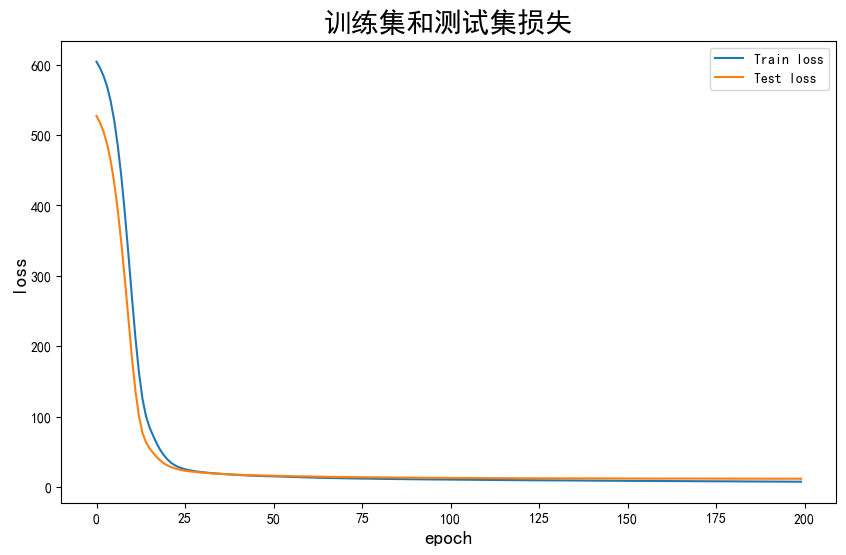

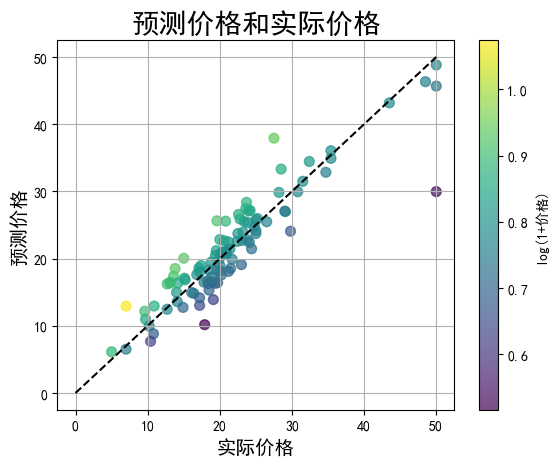


最终结果:
Train RMSE2.7170
Test RMSE:3.4153
MSE:11.6642
MAE:2.3279
R^2:0.8409

示例预测:
输入特征: [-0.4  -0.5  -1.01 -0.28 -0.4   0.14  0.56 -0.55 -0.51 -0.65 -0.77  0.43
 -0.48]
预测价格: 27.43 万美元
真实价格: 23.60 万美元


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import  mean_squared_error,mean_absolute_error,r2_score

# 加载波士顿房价数据集
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data"
column_names = [
    'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 
    'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV'
]

# 从URL加载数据
data = pd.read_csv(url, header=None, delim_whitespace=True, names=column_names)

# 分离特征和目标
X = data.drop('MEDV', axis=1).values
y = data['MEDV'].values.reshape(-1, 1)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(X_train.shape)#训练集特征
print(X_test.shape)#训练集标签/目标值
print(y_train.shape)#测试集特征
print(y_test.shape)#测试集标签/目标值
#数据标准化/归一化处理
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#将数据转换为pytorch的TENSOR
X_train = torch.tensor(X_train,dtype=torch.float32)
y_train = torch.tensor(y_train,dtype=torch.float32)
X_test = torch.tensor(X_test,dtype=torch.float32)
y_test = torch.tensor(y_test,dtype=torch.float32)

#创建数据加载器
train_dataset = TensorDataset(X_train,y_train)
test_dataset = TensorDataset(X_test,y_test)

train_loader = DataLoader(train_dataset,batch_size=64,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=64,shuffle=False)
print(train_loader)
print(test_loader)

#创建神经网络模型
class housing_NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(13,64),
            nn.ReLU(),
            nn.Linear(64,32),
            nn.ReLU(),
            nn.Linear(32,1)
        )
    def forward(self,x):
        return self.network(x)

#初始化模型、损失函数和优化器
model = housing_NN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)

#训练参数
num_epochs = 200
train_losses = []
test_losses = []

#训练模型
for epoch in range(num_epochs):
    #训练模式
    model.train()
    train_loss = 0.0
    for inputs,targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs,targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

    #计算平均训练损失
    train_loss = train_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

     #评估模型
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for inputs,targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs,targets)
            test_loss += loss.item() * inputs.size(0)

    #计算平均测试损失
    test_loss = test_loss / len(test_loader.dataset)
    test_losses.append(test_loss)

    #打印训练进度
    if(epoch+1) % 20 == 0:
        print(f'Epoch[{epoch+1}/{num_epochs}]'f'Train Loss:{train_loss:.4f}'f'Test Loss:{test_loss:.4f}')


import matplotlib.pyplot as plt
import pandas as pd
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False
pre =[]
act = []
for i in range(len(test_dataset)):
    p = model(test_dataset[i][0].unsqueeze(0).float())
    pre.append(p.item())
    act.append(test_dataset[i][1].item())
plt.figure(figsize = (10,6))
plt.plot(train_losses,label = 'Train loss')
plt.plot(test_losses,label = 'Test loss')
plt.xlabel('epoch',fontsize=14)
plt.ylabel('loss',fontsize=14)
plt.title('训练集和测试集损失',fontsize = 20)
plt.legend()
plt.show()
plt.scatter(act,pre,
            c = np.arctan2(pre,act),
            s = 50,
            alpha=0.7,
            cmap = "viridis")
plt.colorbar(label = 'log(1+价格)')
plt.plot([0,50],[0,50],'--k')
plt.xlabel("实际价格",fontsize = 14)
plt.ylabel("预测价格",fontsize = 14)
plt.title("预测价格和实际价格",fontsize = 20)
plt.grid(True)
plt.show()    

#模式评估
model.eval()
with torch.no_grad():
    #训练集评估,计算均方根误差
    train_preds = model(X_train)
    train_rmse = torch.sqrt(criterion(train_preds,y_train))
    mse = mean_squared_error(y_train,train_preds)
    mae = mean_absolute_error(y_train,train_preds)
    r2 = r2_score(y_train,train_preds)
    #测试集评估
    test_preds = model(X_test)
    test_rmse = torch.sqrt(criterion(test_preds,y_test))
    mse = mean_squared_error(y_test,test_preds)
    mae = mean_absolute_error(y_test,test_preds)
    r2 = r2_score(y_test,test_preds)
print(f'\n最终结果:')
print(f'Train RMSE{train_rmse:.4f}')
print(f'Test RMSE:{test_rmse:.4f}')
print(f'MSE:{mse:.4f}')
print(f'MAE:{mae:.4f}')
print(f'R^2:{r2:.4f}')
    #使用测试样本进行预测
sample_input = X_test[0].unsqueeze(0)
model.eval()
with torch.no_grad():
    predicted_value = model(sample_input).item()
    
print(f'\n示例预测:')
print(f'输入特征: {sample_input.squeeze().numpy().round(2)}')
print(f'预测价格: {predicted_value:.2f} 万美元')
print(f'真实价格: {y_test[0].item():.2f} 万美元')

In [ ]:
#数据标准化/归一化处理
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
print(X_train)
print(X_test)

#将数据转换为pytorch的TENSOR
X_train = torch.tensor(X_train,dtype=torch.float32)
y_train = torch.tensor(X_train,dtype=torch.float32)
X_test = torch.tensor(X_test,dtype=torch.float32)
y_test = torch.tensor(y_test,dtype=torch.float32)
print(X_train)
print(y_train)
print(X_test)
print(y_test)



[[ 1.28770177 -0.50032012  1.03323679 ...  0.84534281 -0.07433689
   1.75350503]
 [-0.33638447 -0.50032012 -0.41315956 ...  1.20474139  0.4301838
  -0.5614742 ]
 [-0.40325332  1.01327135 -0.71521823 ... -0.63717631  0.06529747
  -0.65159505]
 ...
 [-0.40547014  2.95931752 -1.30336132 ... -0.59225149  0.37901005
  -0.91069248]
 [ 0.85189733 -0.50032012  1.03323679 ...  0.84534281 -2.69458597
   1.52257036]
 [-0.38135592 -0.50032012 -0.35216694 ...  1.15981657 -3.12158061
  -0.25731635]]
[[-0.39680933 -0.50032012 -1.00711147 ... -0.77195078  0.42887165
  -0.48121032]
 [-0.40079621  1.2294987  -0.66439105 ... -0.32270256  0.44418004
  -1.25709448]
 [-0.39523443 -0.50032012  2.43316256 ...  0.80041799  0.36993437
   0.79033849]
 ...
 [ 1.1779666  -0.50032012  1.03323679 ...  0.84534281 -3.5124912
   1.23390203]
 [-0.40131065 -0.50032012 -0.94321444 ...  0.08162084  0.43422959
   0.05669848]
 [-0.39643252 -0.50032012  0.26792466 ...  0.17147048  0.29470458
  -0.49529171]]
tensor([[ 1.2877, 

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_21496\891216125.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(X_train,dtype=torch.float32)


In [ ]:
#创建数据加载器
train_dataset = TensorDataset(X_train,y_train)
test_dataset = TensorDataset(X_test,y_test)

train_loader = DataLoader(train_data,batch_size=32,shuffle=True)
test_loader = DataLoader(test_data,batch_size=32,shuffle=False)
print(train_loader)
print(test_loader)



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
#创建神经网络模型
class housing_NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(13,64),
            nn.ReLU(),
            nn.Linear(64,32),
            nn.ReLU(),
            nn.Linear(32,1)
        )
    def forward(self,x):
        return self.network(X)
net=housing_NN()
print(net)

housing_NN(
  (network): Sequential(
    (0): Linear(in_features=13, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [ ]:
#初始化模型、损失函数和优化器
model = housing_NN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)

#训练参数
num_epochs = 200
train_losses = []
test_losses = []

#训练模型
for epoch in range(num_epochs):
    #训练模式
    model.train()
    train_loss = 0.0
    for inputs,targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs,targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

    #计算平均训练损失
    train_loss = train_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

     #评估模型
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for inputs,targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs,targets)
            test_loss += loss.item() * inputs.size(0)

    #计算平均测试损失
    test_loss = test_loss / len(test_loader.dataset)
    test_losses.append(test_loss)

    #打印训练进度
    if(epoch+1) % 20 == 0:
        print(f'Epoch[{epoch+1}/{num_epochs}]'f'Train Loss:{train_loss:.4f}'f'Test Loss:{test_loss:.4f}')


        



Epoch[20/200]Train Loss:23.5278Test Loss:23.5815
Epoch[40/200]Train Loss:14.7747Test Loss:16.5614
Epoch[60/200]Train Loss:11.2552Test Loss:13.5592
Epoch[80/200]Train Loss:9.5741Test Loss:12.5670
Epoch[100/200]Train Loss:8.4428Test Loss:12.0374
Epoch[120/200]Train Loss:7.5747Test Loss:11.7513
Epoch[140/200]Train Loss:6.8075Test Loss:11.6070
Epoch[160/200]Train Loss:6.2557Test Loss:11.4684
Epoch[180/200]Train Loss:5.6831Test Loss:11.2416
Epoch[200/200]Train Loss:5.2562Test Loss:11.1221


In [ ]:
from sklearn.metrics import  mean_squared_error,mean_absolute_error,r2_score
#模式评估
model.eval()
with torch.no_grad():
    #训练集评估,计算均方根误差
    train_preds = model(X_train)
    train_rmse = torch.sqrt(criterion(train_preds,y_train))
    mse = mean_squared_error(y_train,train_preds)
    mae = mean_absolute_error(y_train,train_preds)
    r2 = r2_score(y_train,train_preds)
    #测试集评估
    test_preds = model(X_test)
    test_rmse = torch.sqrt(criterion(test_preds,y_test))
    mse = mean_squared_error(y_test,test_preds)
    mae = mean_absolute_error(y_test,test_preds)
    r2 = r2_score(y_test,test_preds)
print(f'\n最终结果:')
print(f'Train RMSE{train_rmse:.4f}')
print(f'Test RMSE:{test_rmse:.4f}')
print(f'MSE:{mse:.4f}')
print(f'MAE:{mae:.4f}')
print(f'R^2:{r2:.4f}')
    #使用测试样本进行预测
sample_input = X_test[0].unsqueeze(0)
model.eval()
with torch.no_grad():
    predicted_value = model(sample_input).item()
    
print(f'\n示例预测:')
print(f'输入特征: {sample_input.squeeze().numpy().round(2)}')
print(f'预测价格: {predicted_value:.2f} 万美元')
print(f'真实价格: {y_test[0].item():.2f} 万美元')


最终结果:
Train RMSE2.5781
Test RMSE:3.2713
MSE:10.7012
MAE:2.1807
R^2:0.8541

示例预测:
输入特征: [-0.4  -0.5  -1.01 -0.28 -0.4   0.14  0.56 -0.55 -0.51 -0.65 -0.77  0.43
 -0.48]
预测价格: 27.34 万美元
真实价格: 23.60 万美元


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 加载波士顿房价数据集（需要科学上网或使用本地数据）
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data"
column_names = [
    'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 
    'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV'
]

# 从URL加载数据
data = pd.read_csv(url, header=None, delim_whitespace=True, names=column_names)


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_21496\1751281726.py:19: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(url, header=None, delim_whitespace=True, names=column_names)


In [ ]:
# 分离特征和目标
X = data.drop('MEDV', axis=1).values
y = data['MEDV'].values.reshape(-1, 1)
print(X)
print(y)

[[6.3200e-03 1.8000e+01 2.3100e+00 ... 1.5300e+01 3.9690e+02 4.9800e+00]
 [2.7310e-02 0.0000e+00 7.0700e+00 ... 1.7800e+01 3.9690e+02 9.1400e+00]
 [2.7290e-02 0.0000e+00 7.0700e+00 ... 1.7800e+01 3.9283e+02 4.0300e+00]
 ...
 [6.0760e-02 0.0000e+00 1.1930e+01 ... 2.1000e+01 3.9690e+02 5.6400e+00]
 [1.0959e-01 0.0000e+00 1.1930e+01 ... 2.1000e+01 3.9345e+02 6.4800e+00]
 [4.7410e-02 0.0000e+00 1.1930e+01 ... 2.1000e+01 3.9690e+02 7.8800e+00]]
[[24. ]
 [21.6]
 [34.7]
 [33.4]
 [36.2]
 [28.7]
 [22.9]
 [27.1]
 [16.5]
 [18.9]
 [15. ]
 [18.9]
 [21.7]
 [20.4]
 [18.2]
 [19.9]
 [23.1]
 [17.5]
 [20.2]
 [18.2]
 [13.6]
 [19.6]
 [15.2]
 [14.5]
 [15.6]
 [13.9]
 [16.6]
 [14.8]
 [18.4]
 [21. ]
 [12.7]
 [14.5]
 [13.2]
 [13.1]
 [13.5]
 [18.9]
 [20. ]
 [21. ]
 [24.7]
 [30.8]
 [34.9]
 [26.6]
 [25.3]
 [24.7]
 [21.2]
 [19.3]
 [20. ]
 [16.6]
 [14.4]
 [19.4]
 [19.7]
 [20.5]
 [25. ]
 [23.4]
 [18.9]
 [35.4]
 [24.7]
 [31.6]
 [23.3]
 [19.6]
 [18.7]
 [16. ]
 [22.2]
 [25. ]
 [33. ]
 [23.5]
 [19.4]
 [22. ]
 [17.4]
 [20

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
print(X_train.shape)#训练集标签/目标值
print(X_test.shape)#训练集特征
print(y_train.shape)#测试集标签/目标值
print(y_test.shape)#测试集特征

(404, 13)
(102, 13)
(404, 1)
(102, 1)


In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
print(X_train)
print(X_test)

#将数据转换为pytorch的TENSOR
X_train = torch.tensor(X_train,dtype=torch.float32)
y_train = torch.tensor(X_train,dtype=torch.float32)
X_test = torch.tensor(X_test,dtype=torch.float32)
y_test = torch.tensor(y_test,dtype=torch.float32)
print(X_train)
print(y_train)
print(X_test)
print(y_test)

[[ 1.28770177 -0.50032012  1.03323679 ...  0.84534281 -0.07433689
   1.75350503]
 [-0.33638447 -0.50032012 -0.41315956 ...  1.20474139  0.4301838
  -0.5614742 ]
 [-0.40325332  1.01327135 -0.71521823 ... -0.63717631  0.06529747
  -0.65159505]
 ...
 [-0.40547014  2.95931752 -1.30336132 ... -0.59225149  0.37901005
  -0.91069248]
 [ 0.85189733 -0.50032012  1.03323679 ...  0.84534281 -2.69458597
   1.52257036]
 [-0.38135592 -0.50032012 -0.35216694 ...  1.15981657 -3.12158061
  -0.25731635]]
[[-0.39680933 -0.50032012 -1.00711147 ... -0.77195078  0.42887165
  -0.48121032]
 [-0.40079621  1.2294987  -0.66439105 ... -0.32270256  0.44418004
  -1.25709448]
 [-0.39523443 -0.50032012  2.43316256 ...  0.80041799  0.36993437
   0.79033849]
 ...
 [ 1.1779666  -0.50032012  1.03323679 ...  0.84534281 -3.5124912
   1.23390203]
 [-0.40131065 -0.50032012 -0.94321444 ...  0.08162084  0.43422959
   0.05669848]
 [-0.39643252 -0.50032012  0.26792466 ...  0.17147048  0.29470458
  -0.49529171]]
tensor([[ 1.2877, 

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_21496\2788586198.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(X_train,dtype=torch.float32)


In [ ]:
#创建数据加载器
train_dataset = TensorDataset(X_train,y_train)
test_dataset = TensorDataset(X_test,y_test)

train_loader = DataLoader(train_dataset,batch_size=64,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=64,shuffle=False)
print(train_loader)
print(test_loader)

In [ ]:

#创建神经网络模型
class housing_NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(13,64),
            nn.ReLU(),
            nn.Linear(64,32),
            nn.ReLU(),
            nn.Linear(32,1)
        )
    def forward(self,x):
        return self.network(x)
net=housing_NN()
print(net)

housing_NN(
  (network): Sequential(
    (0): Linear(in_features=13, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [ ]:
#初始化模型、损失函数和优化器
model = housing_NN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)

#训练参数
num_epochs = 200
train_losses = []
test_losses = []

#训练模型
for epoch in range(num_epochs):
    #训练模式
    model.train()
    train_loss = 0.0
    for inputs,targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs,targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

    #计算平均训练损失
    train_loss = train_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

     #评估模型
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for inputs,targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs,targets)
            test_loss += loss.item() * inputs.size(0)

    #计算平均测试损失
    test_loss = test_loss / len(test_loader.dataset)
    test_losses.append(test_loss)

    #打印训练进度
    if(epoch+1) % 20 == 0:
        print(f'Epoch[{epoch+1}/{num_epochs}]'f'Train Loss:{train_loss:.4f}'f'Test Loss:{test_loss:.4f}')

Epoch[20/200]Train Loss:54.1699Test Loss:42.2575
Epoch[40/200]Train Loss:19.6355Test Loss:21.7318
Epoch[60/200]Train Loss:14.4154Test Loss:17.2203
Epoch[80/200]Train Loss:11.9289Test Loss:15.1009
Epoch[100/200]Train Loss:10.6643Test Loss:14.0516
Epoch[120/200]Train Loss:9.7919Test Loss:13.4355
Epoch[140/200]Train Loss:9.0830Test Loss:12.9551
Epoch[160/200]Train Loss:8.5091Test Loss:12.7169
Epoch[180/200]Train Loss:7.9757Test Loss:12.3113
Epoch[200/200]Train Loss:7.5890Test Loss:12.3805


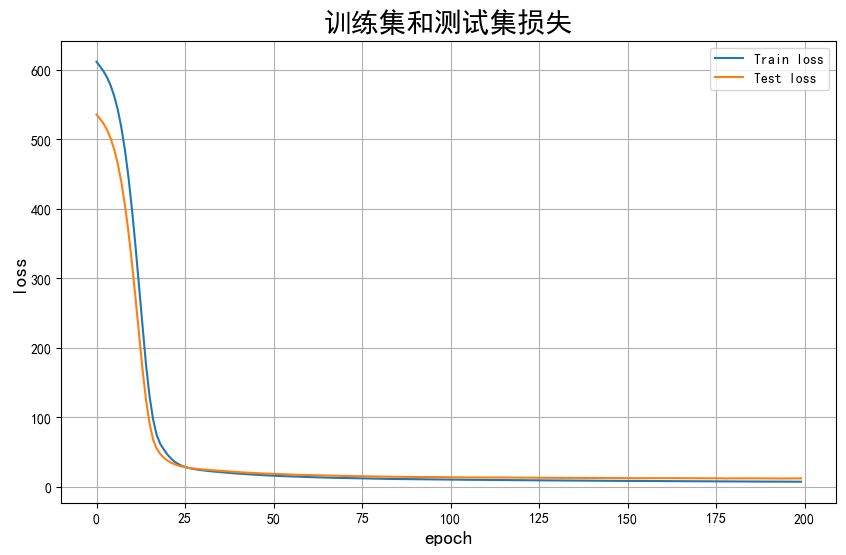

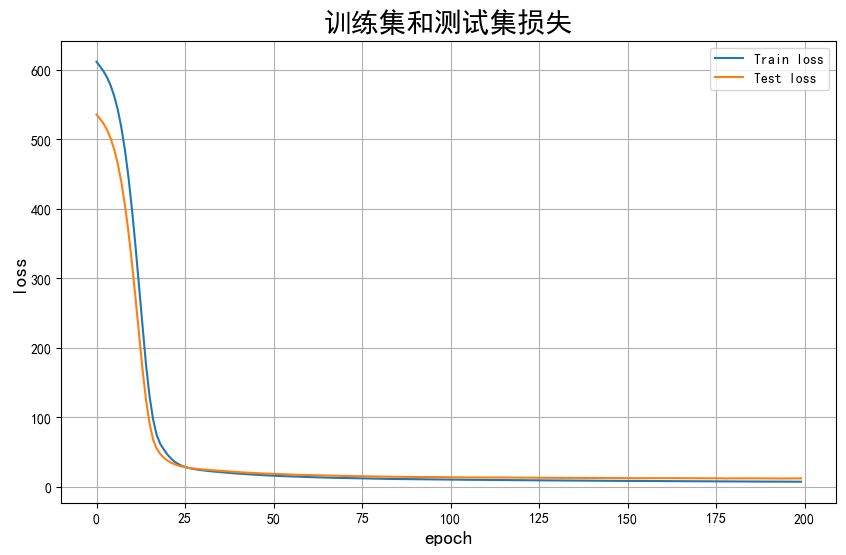

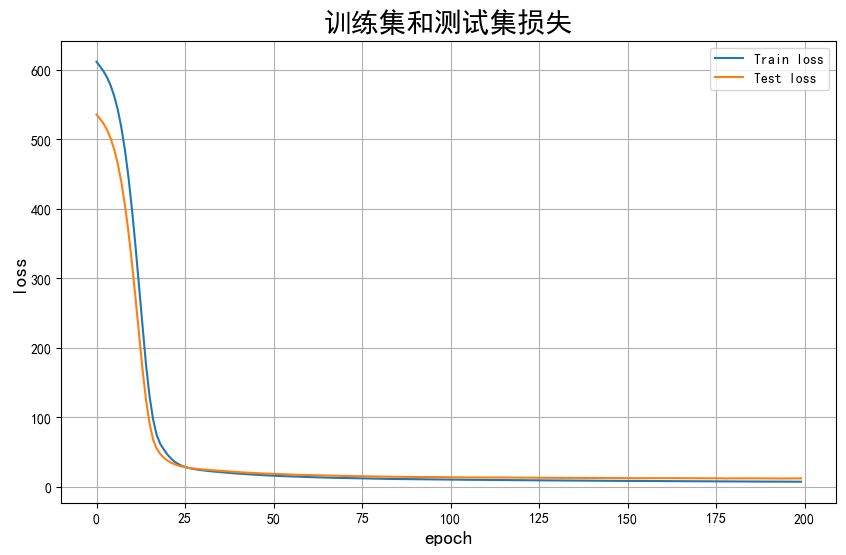

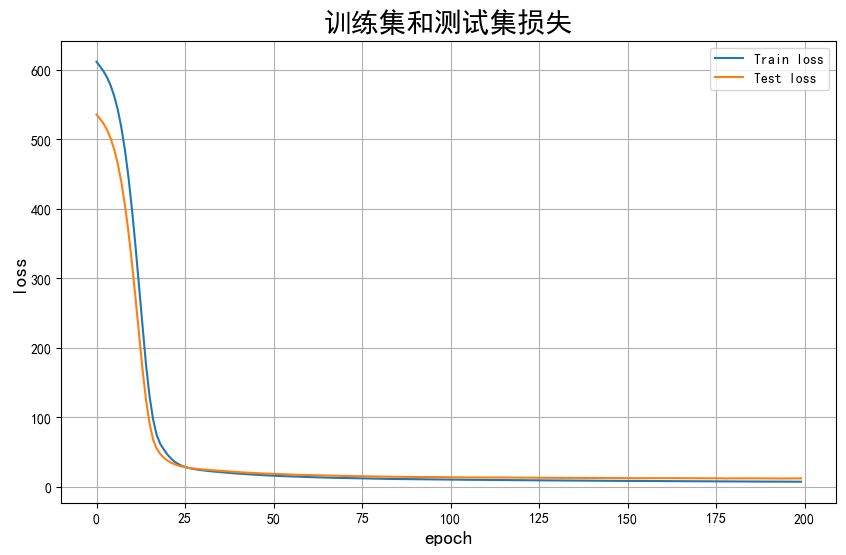

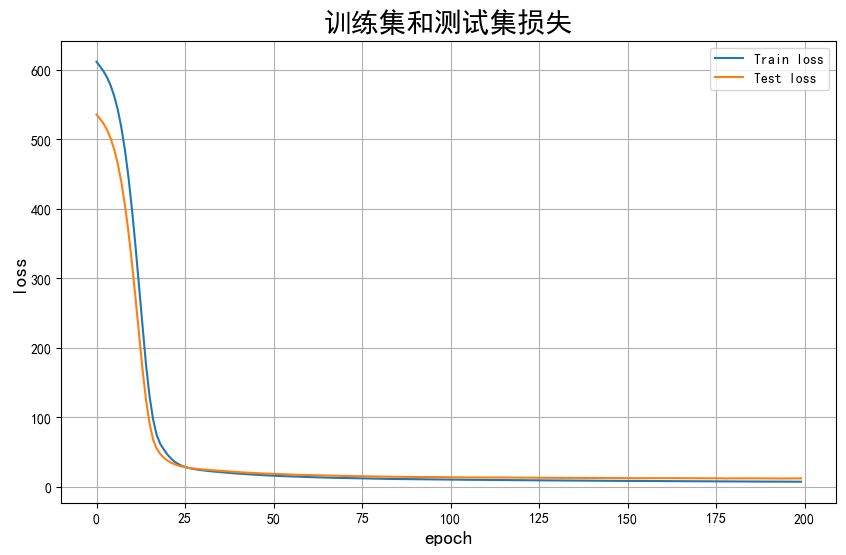

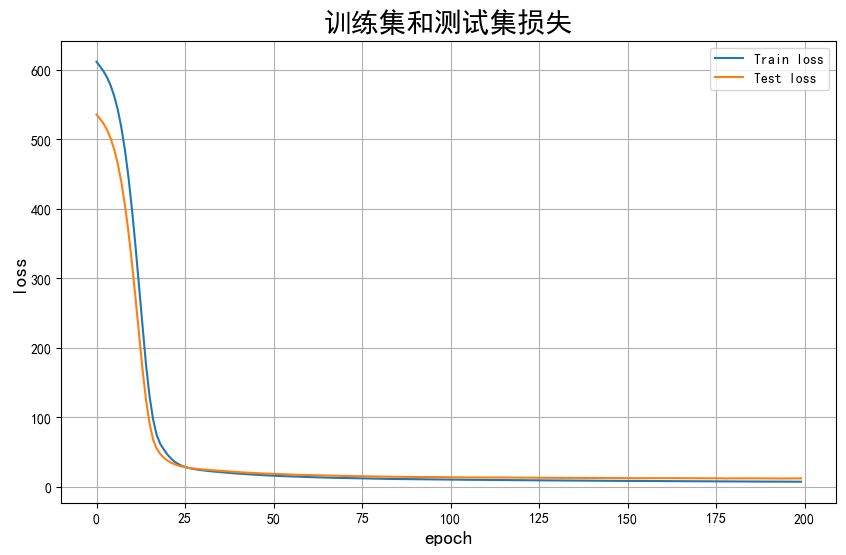

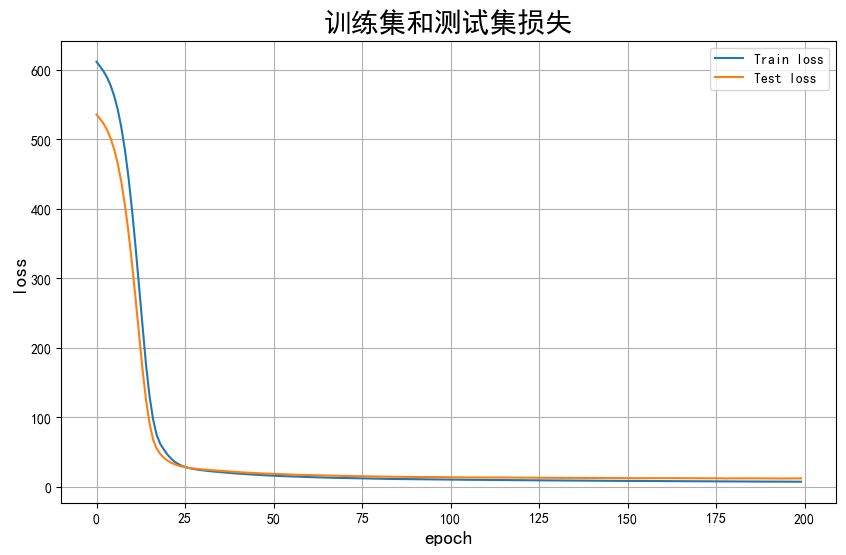

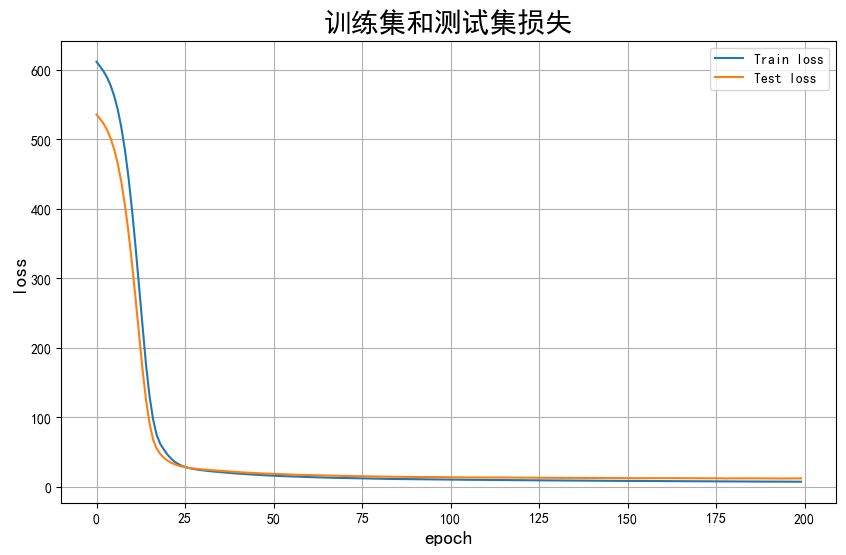

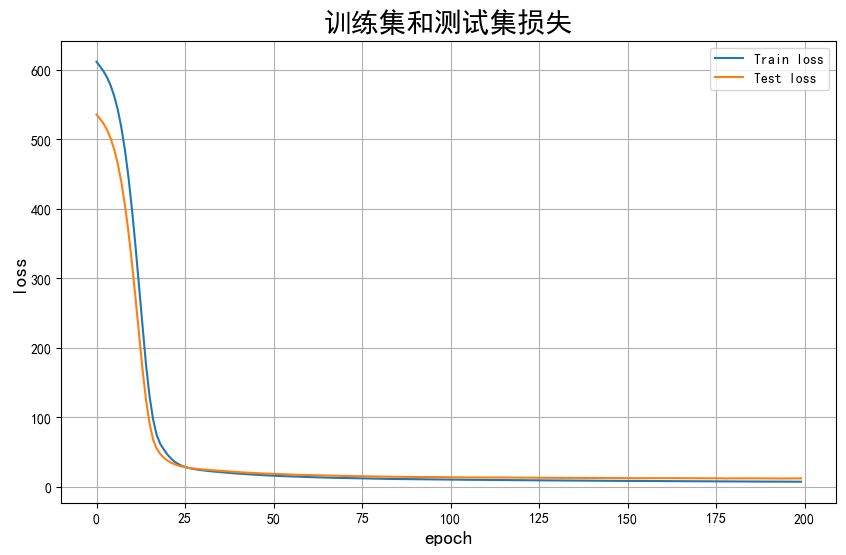

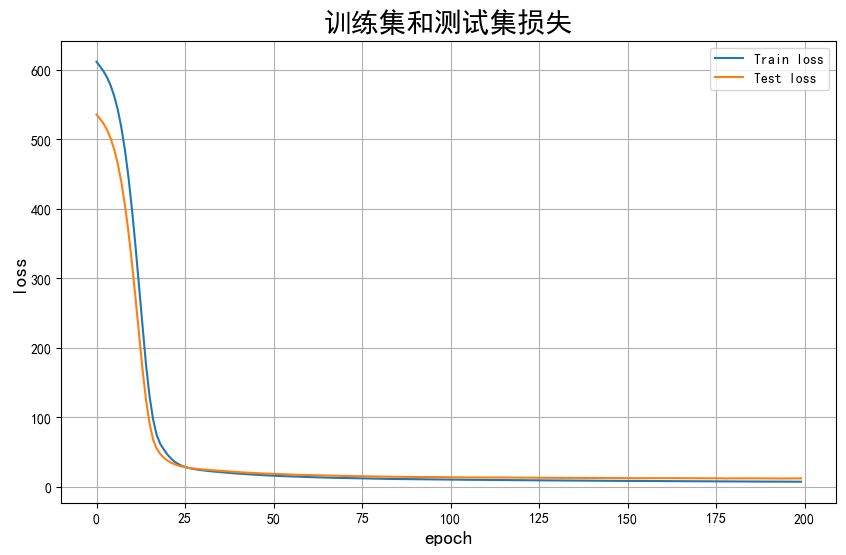

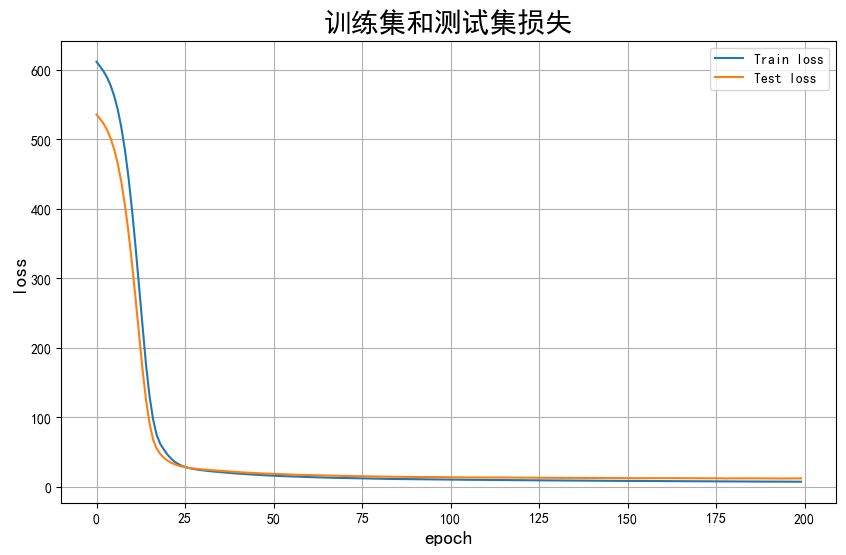

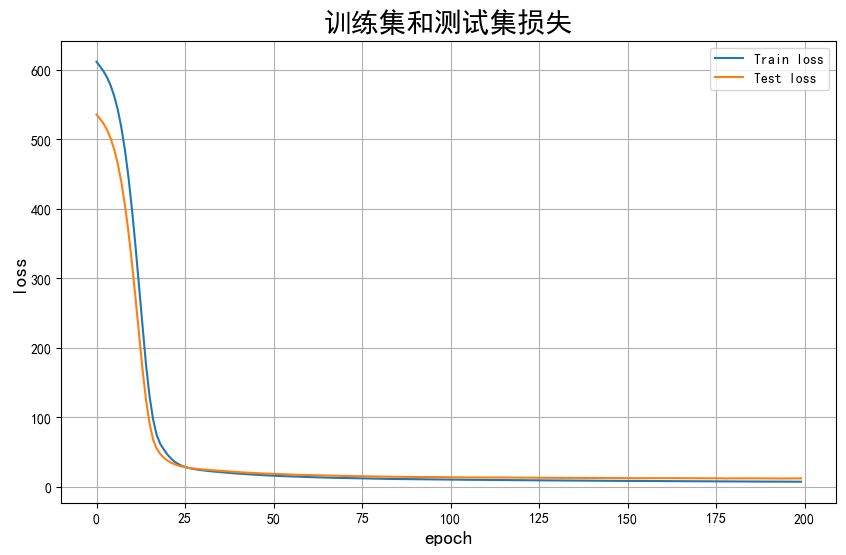

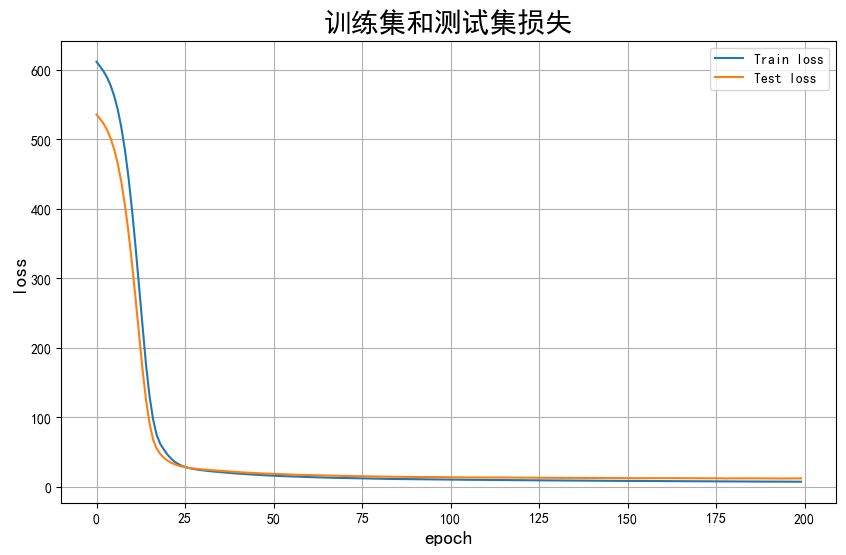

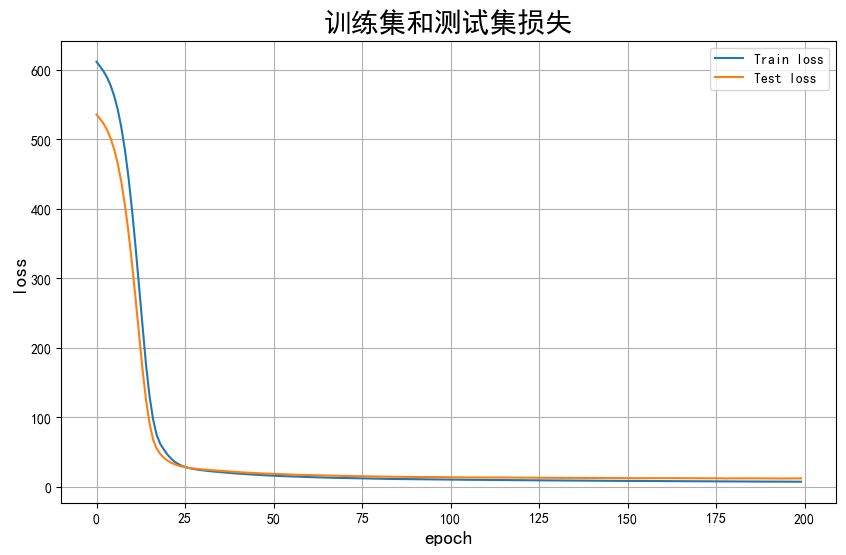

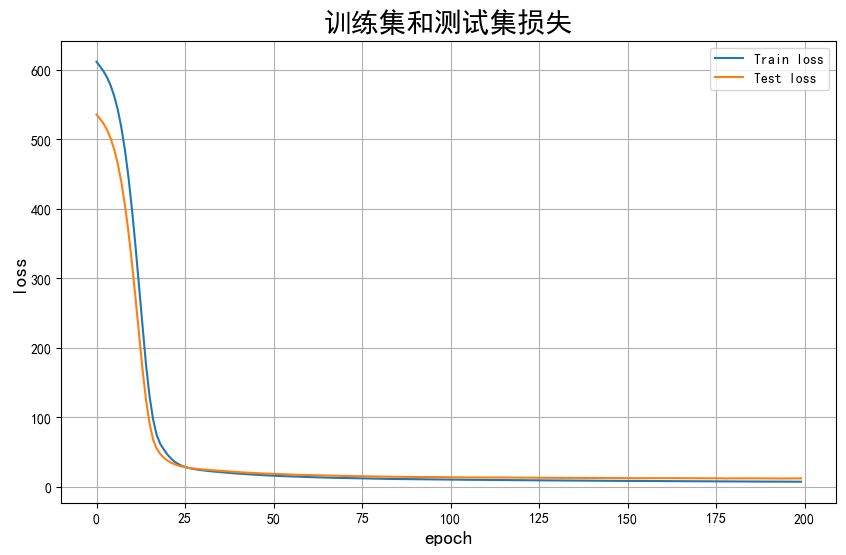

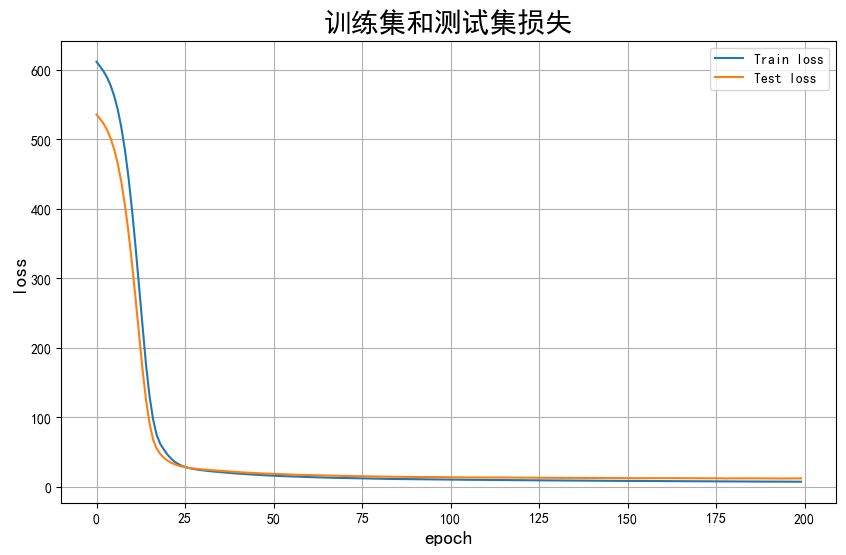

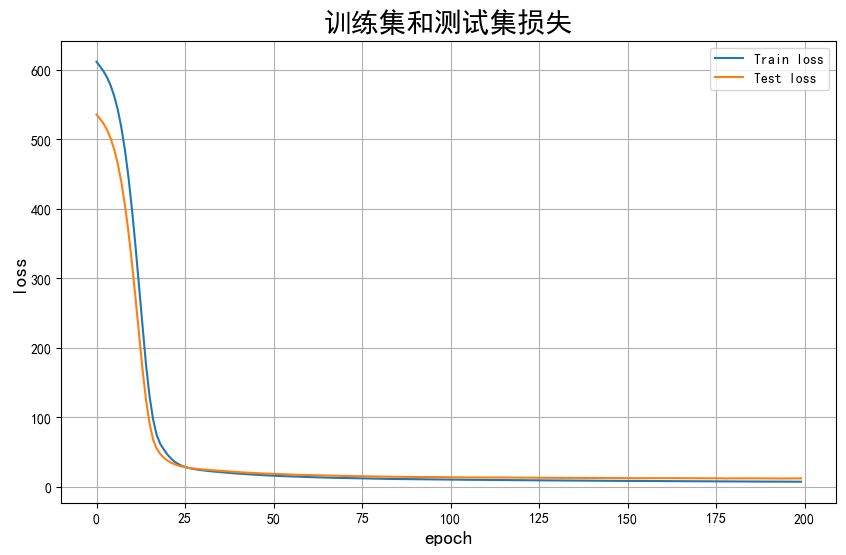

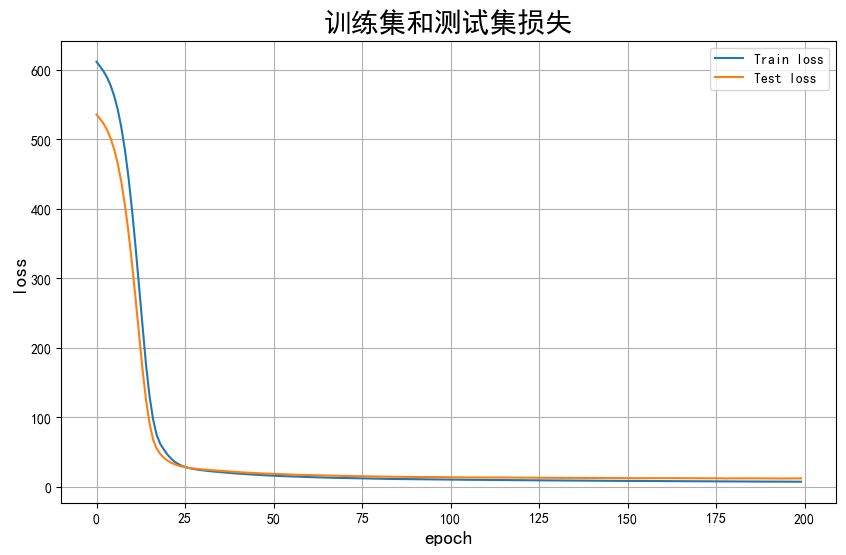

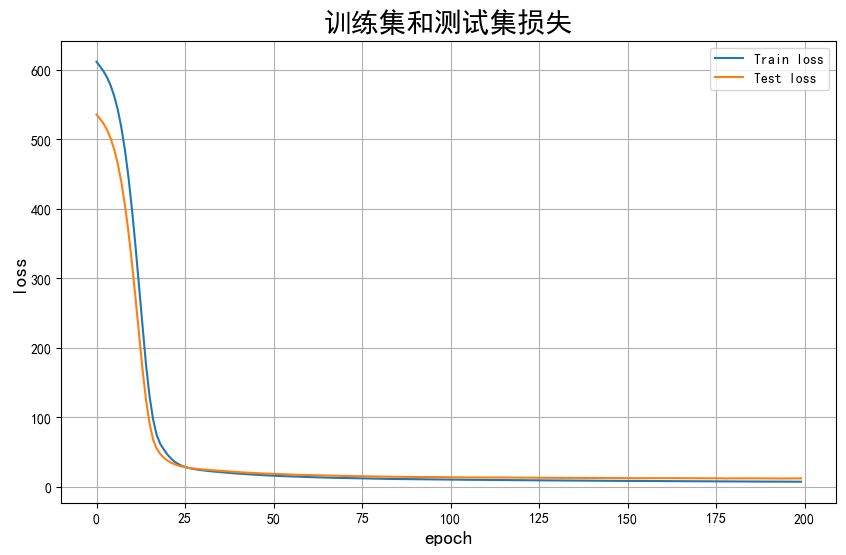

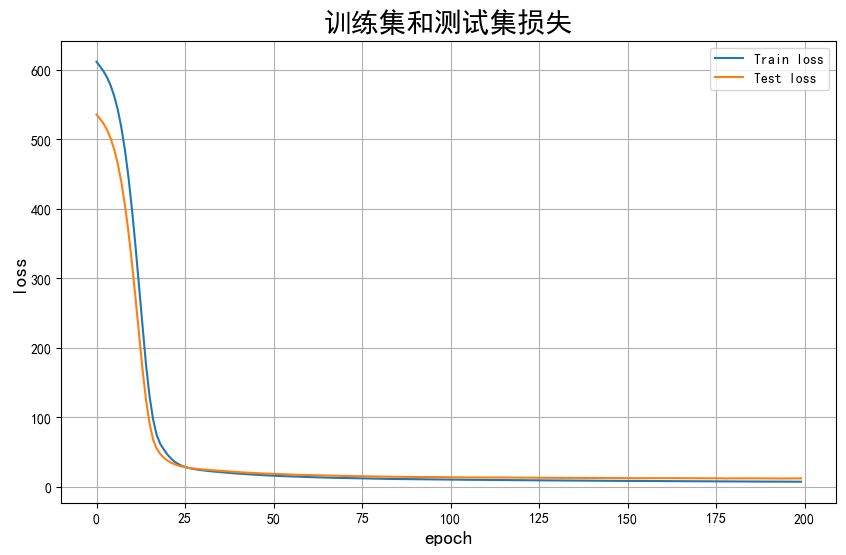

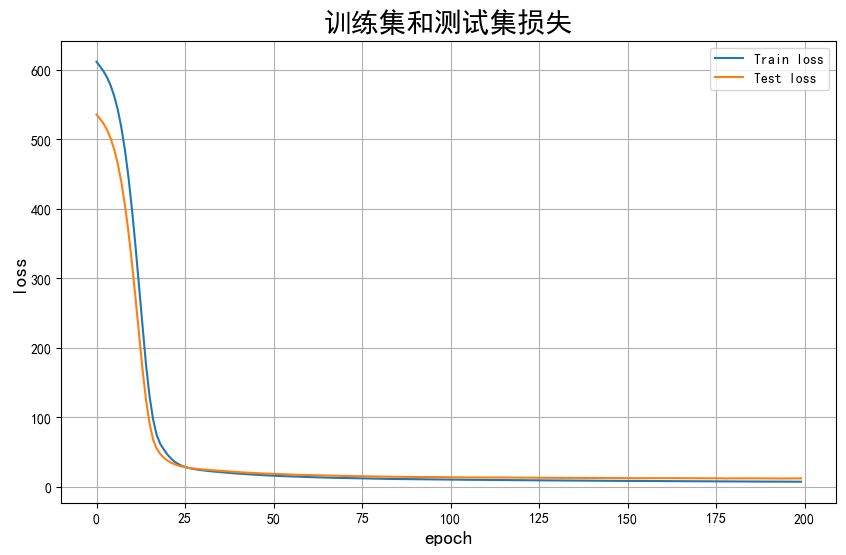

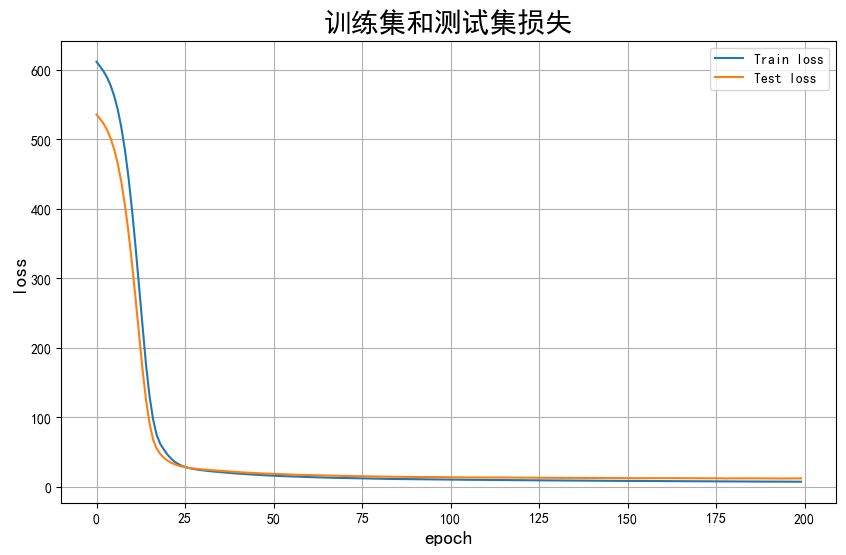

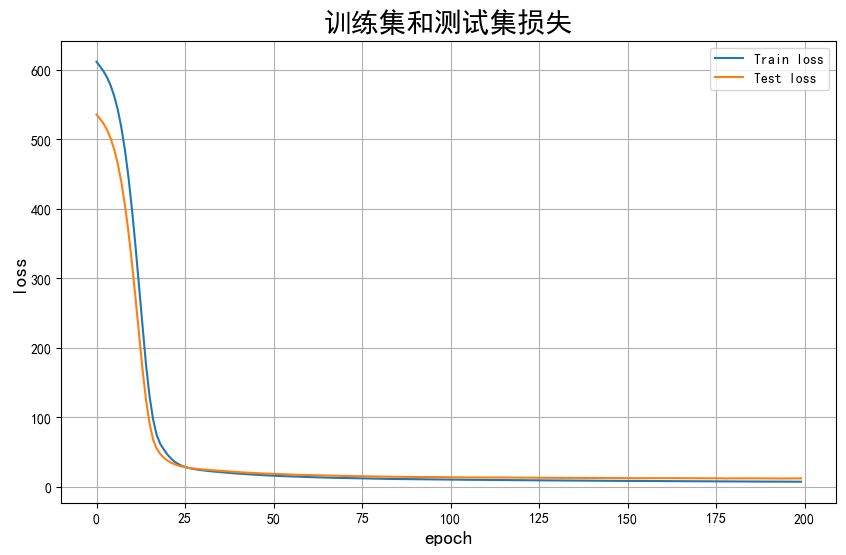

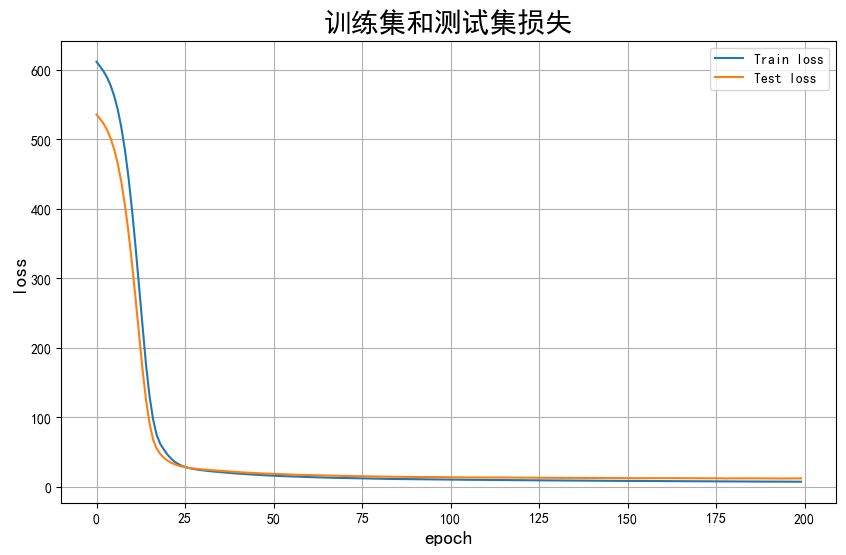

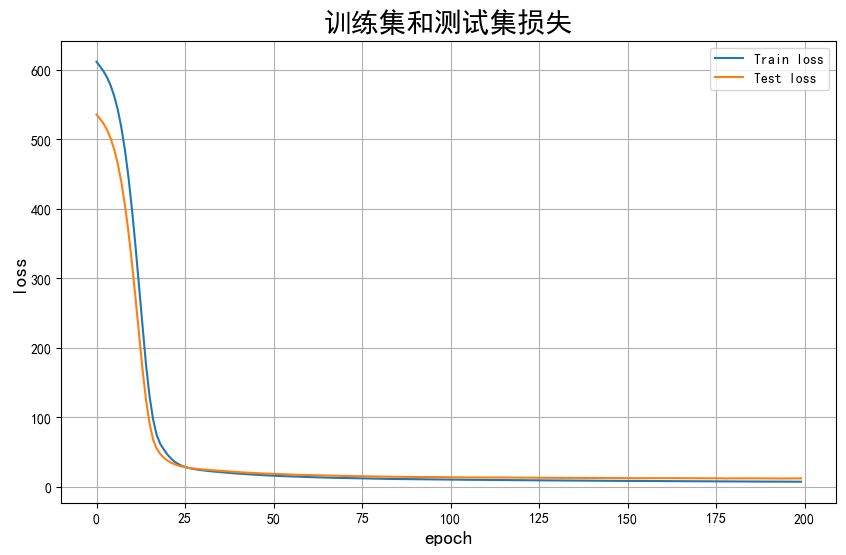

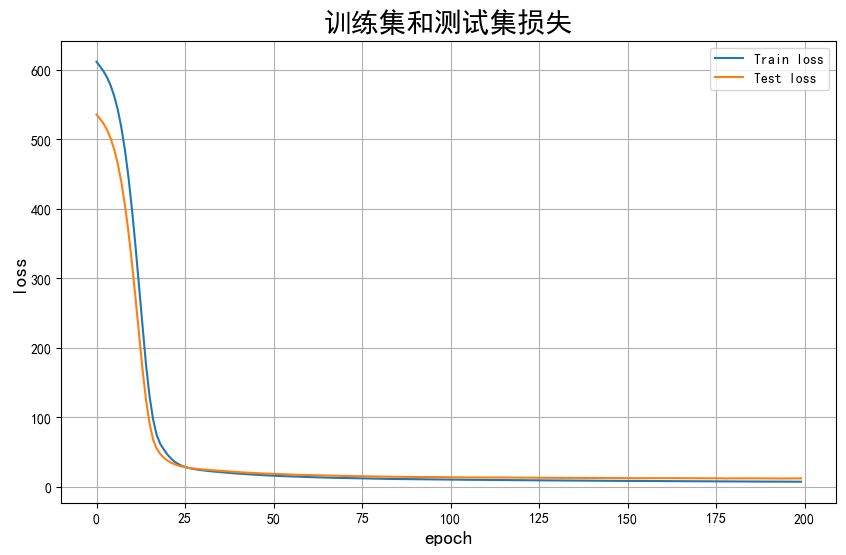

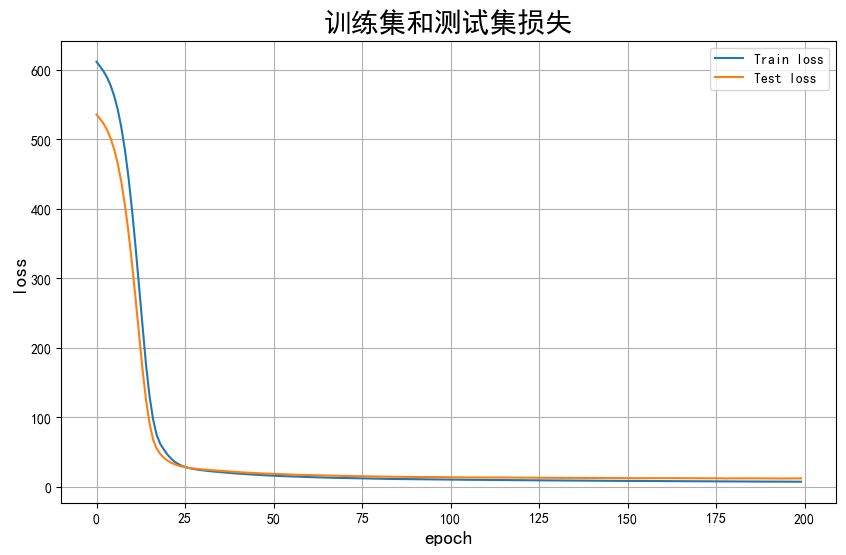

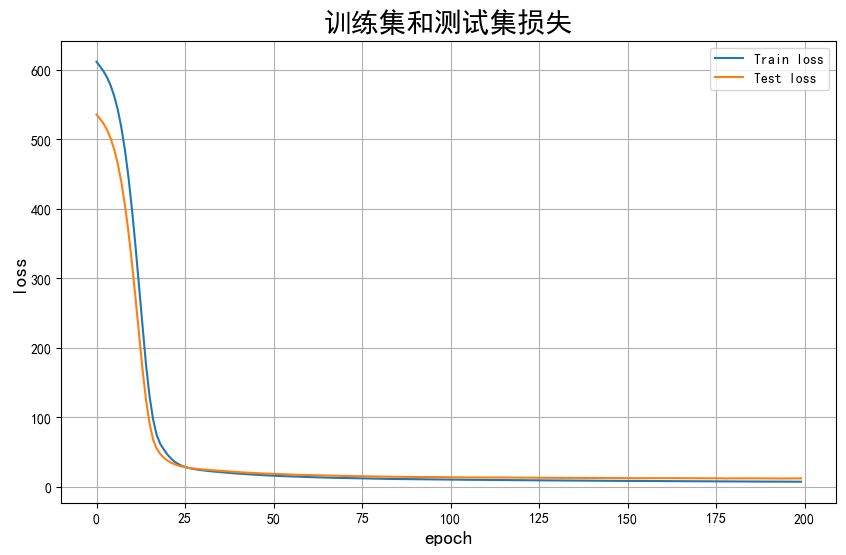

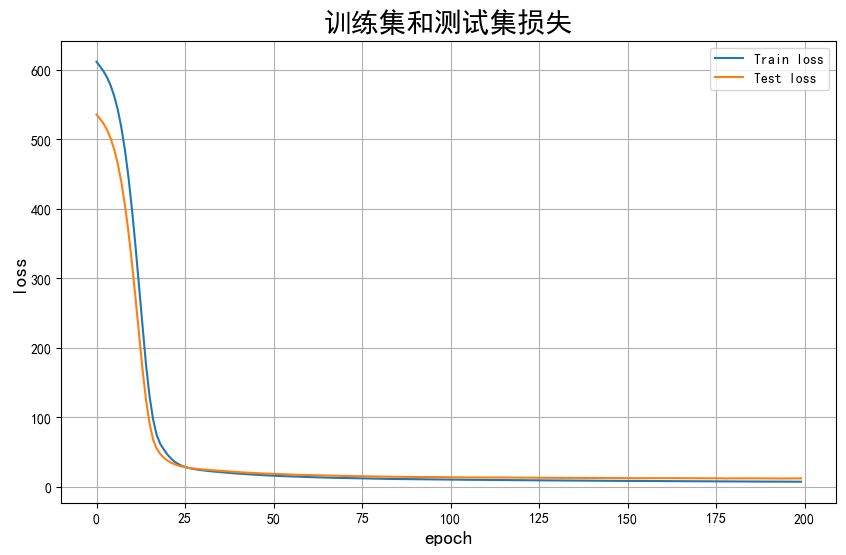

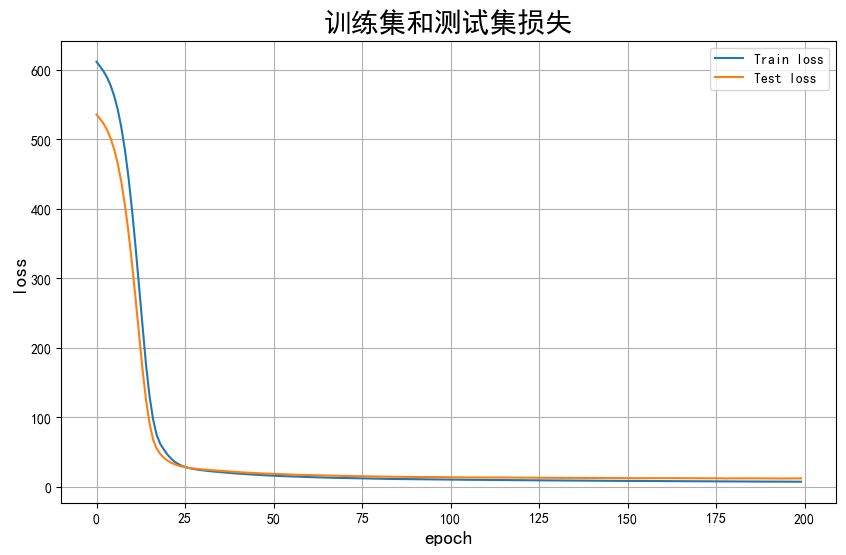

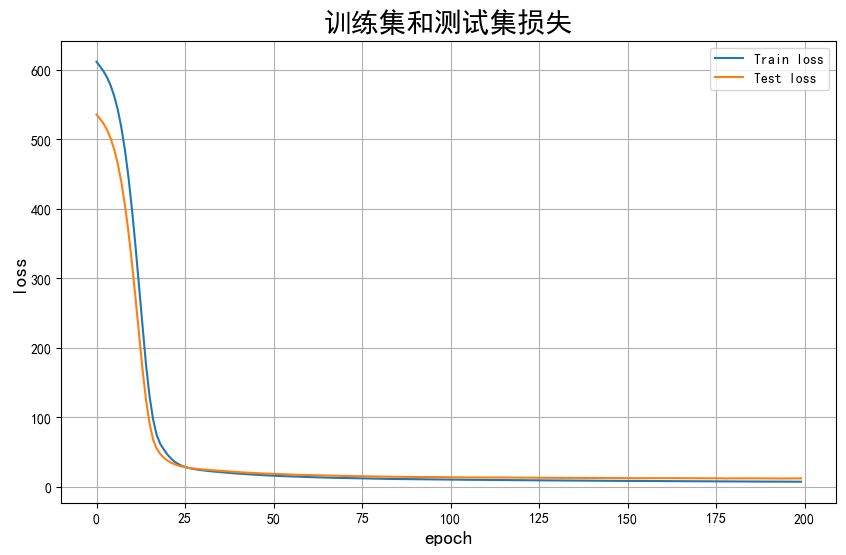

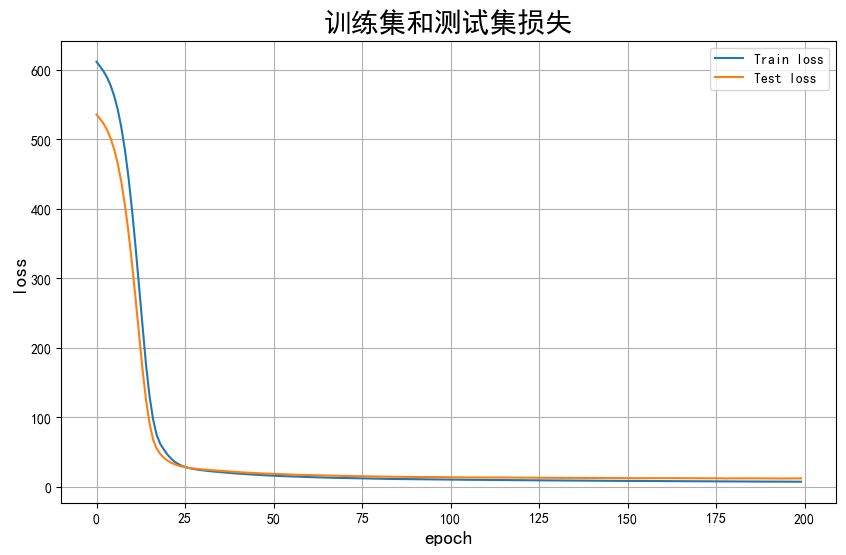

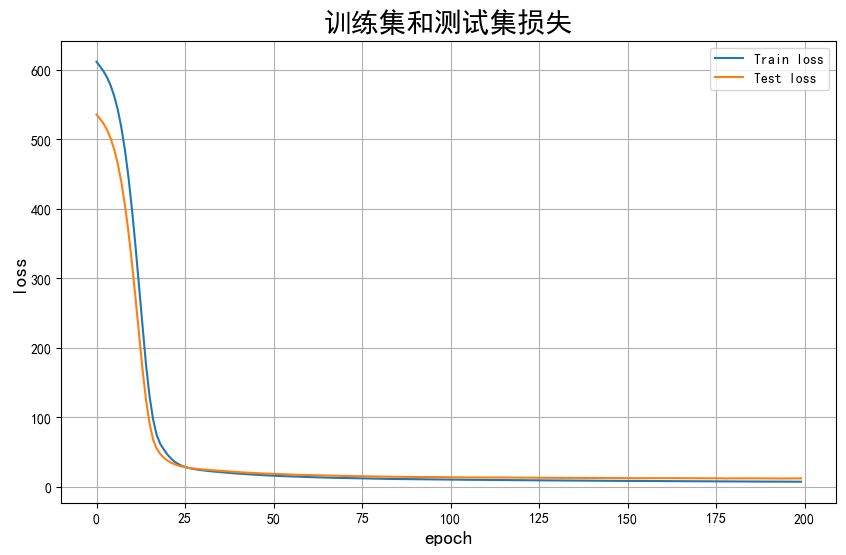

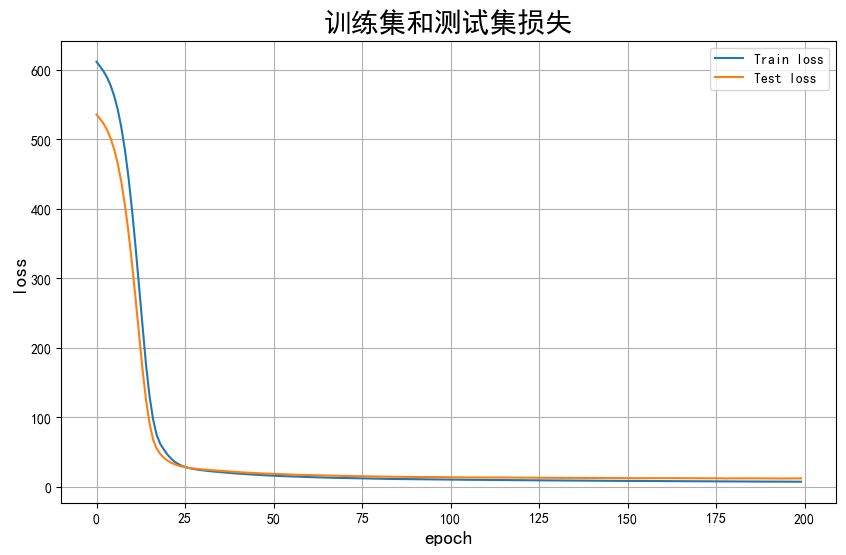

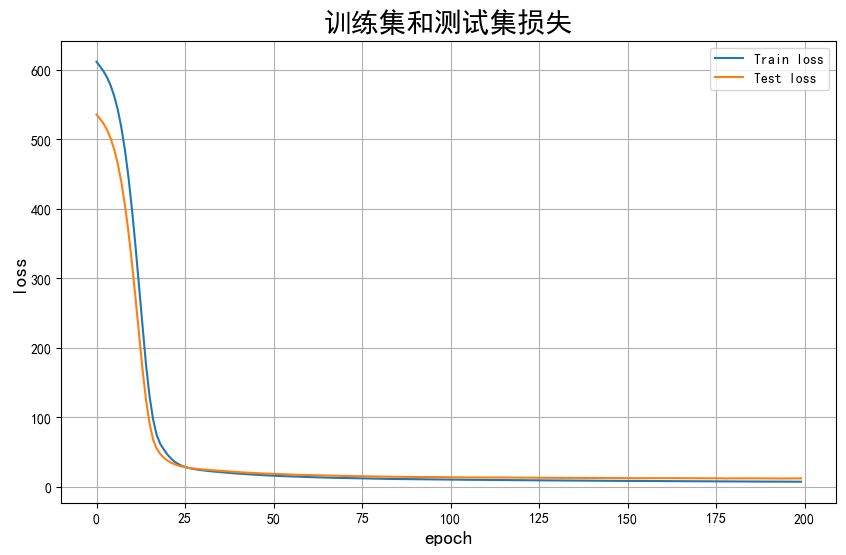

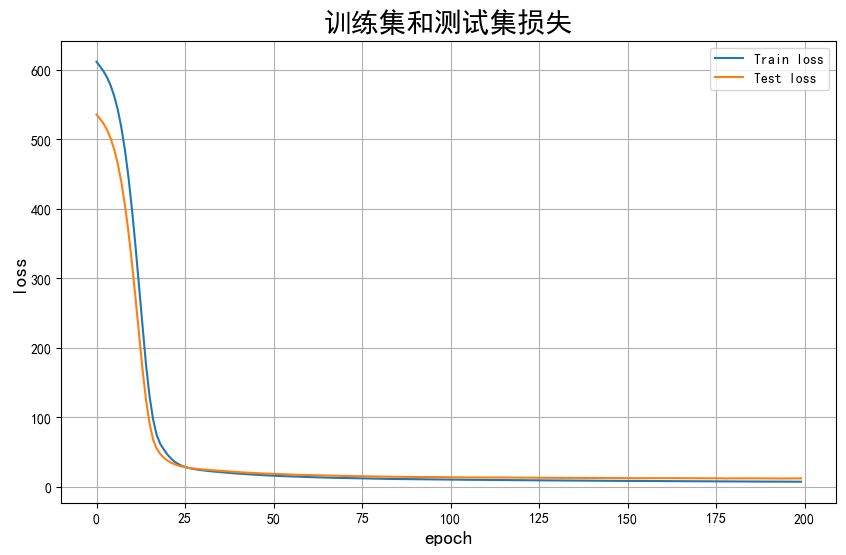

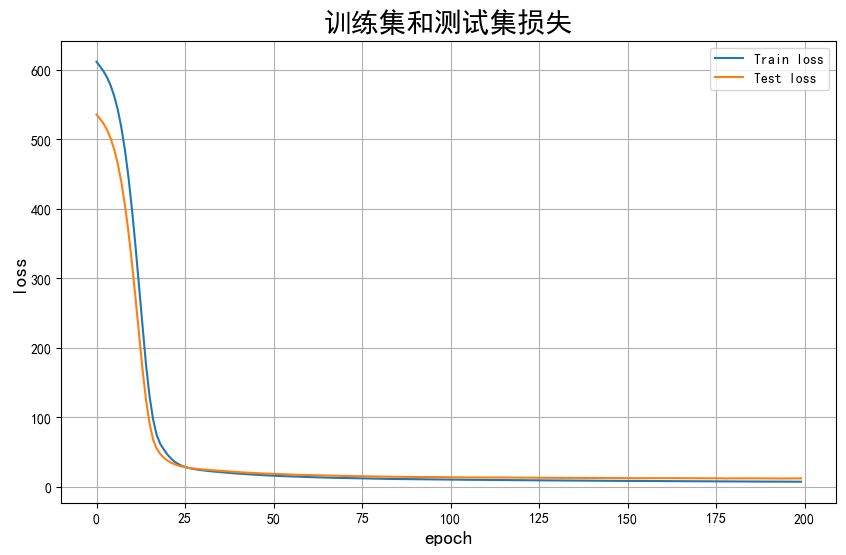

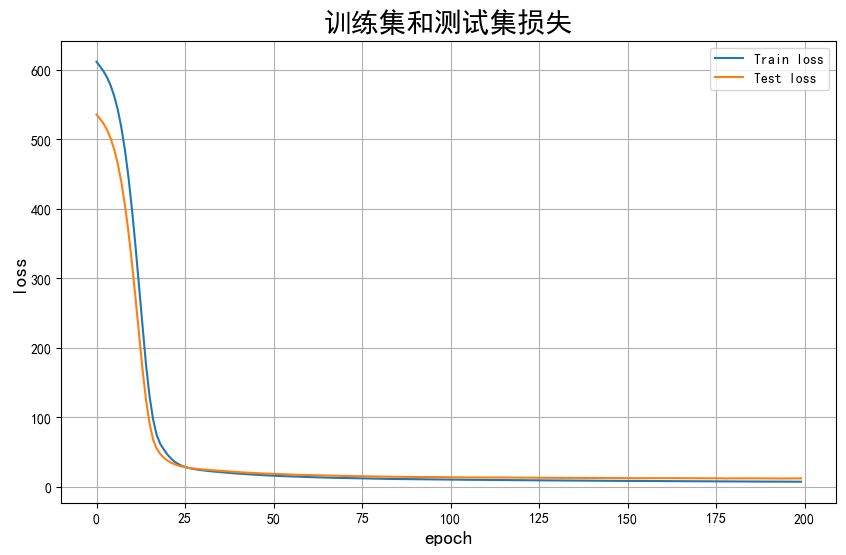

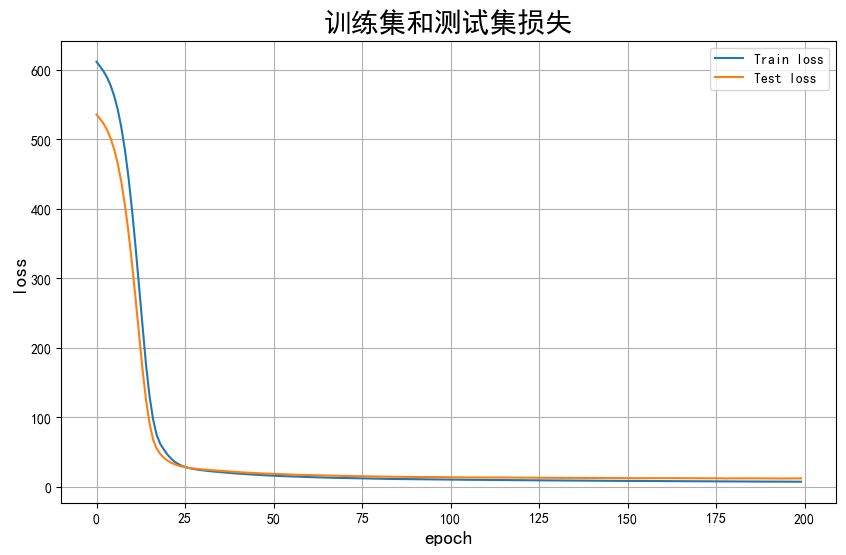

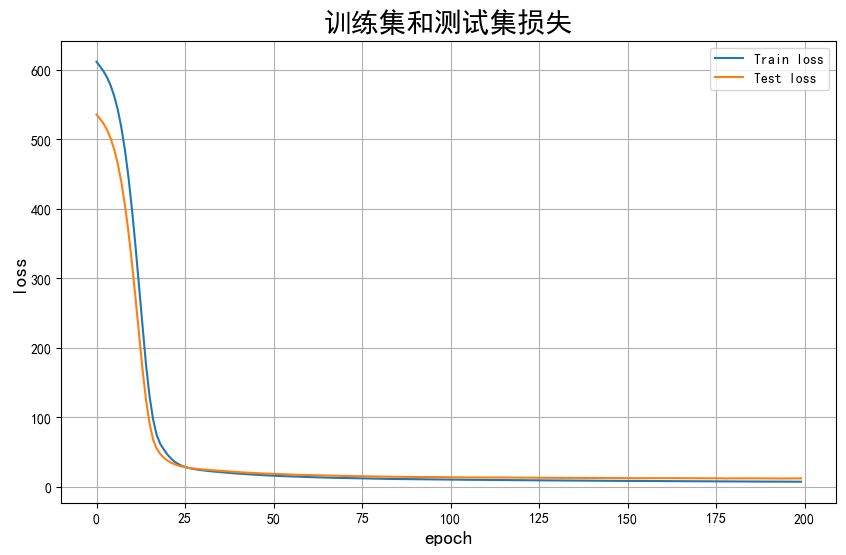

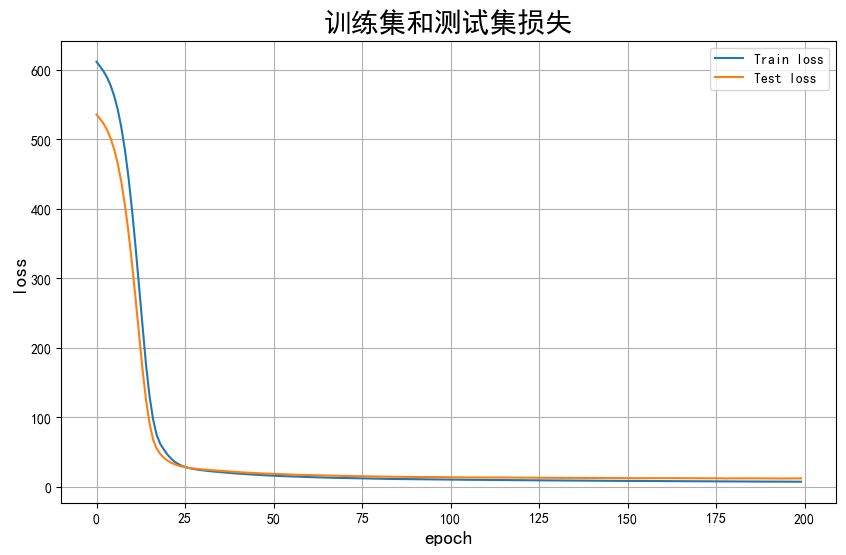

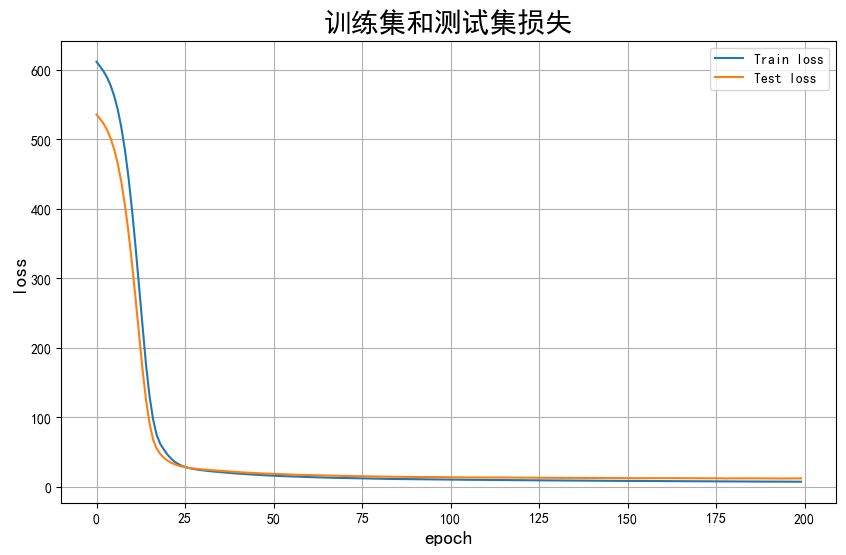

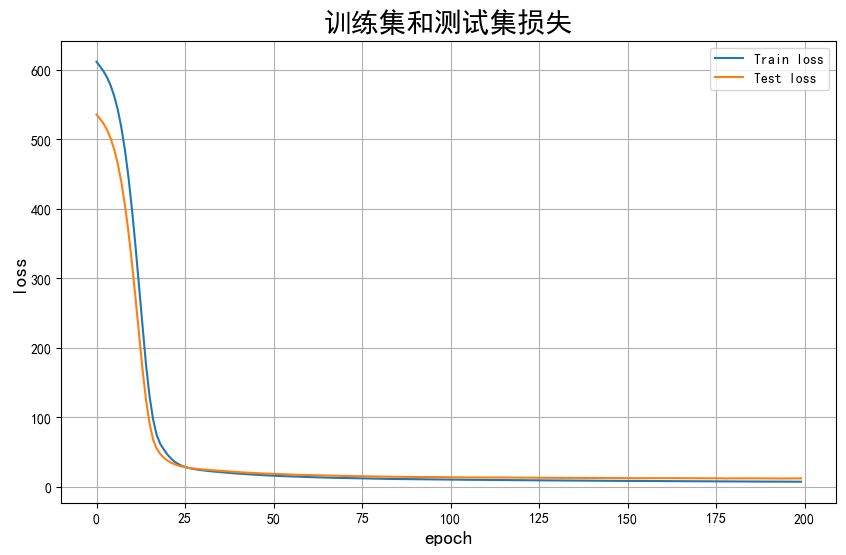

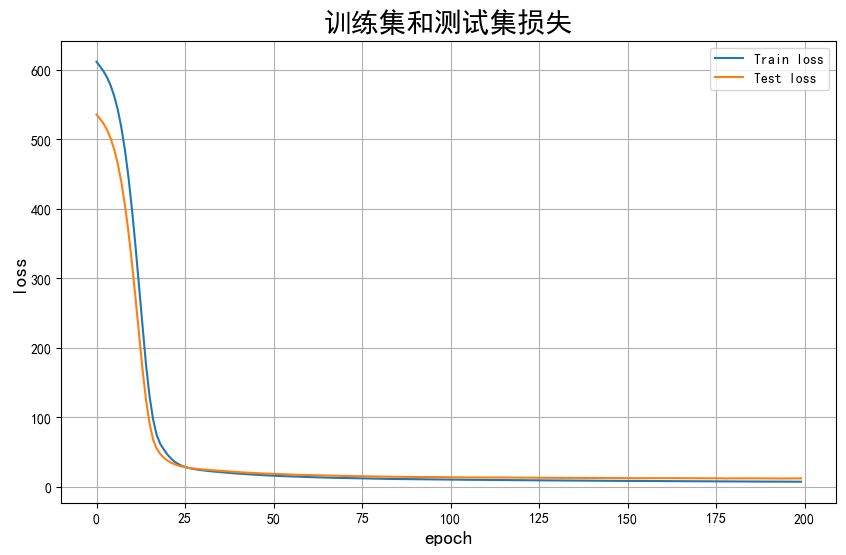

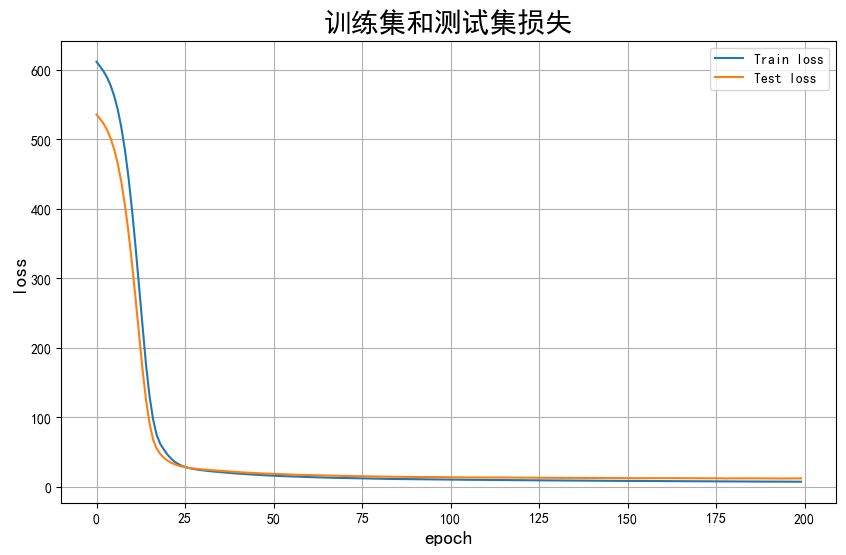

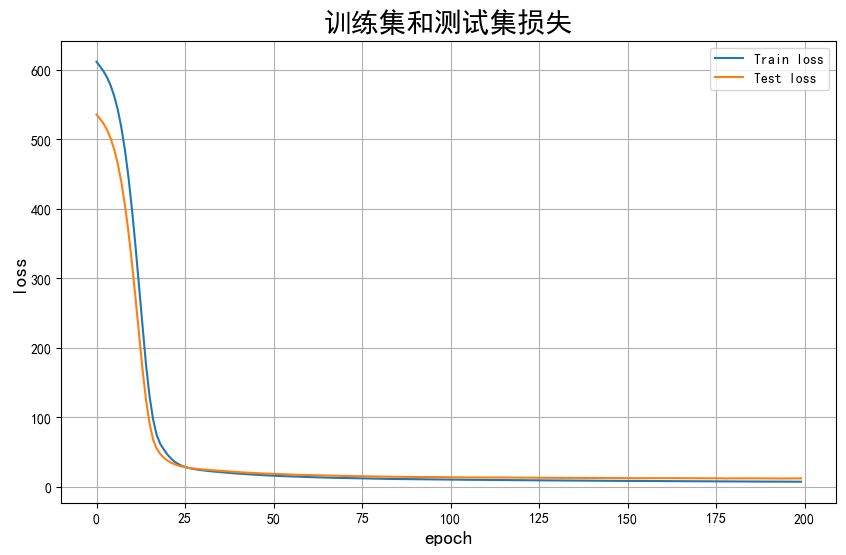

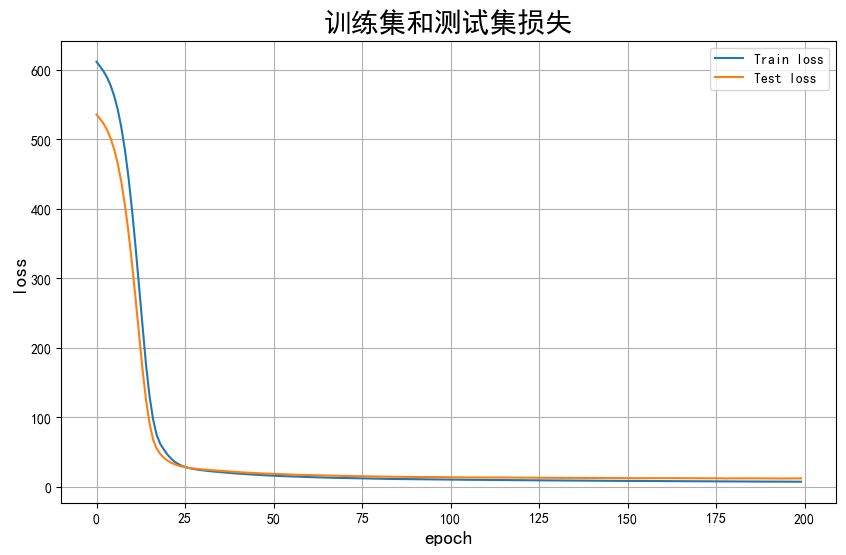

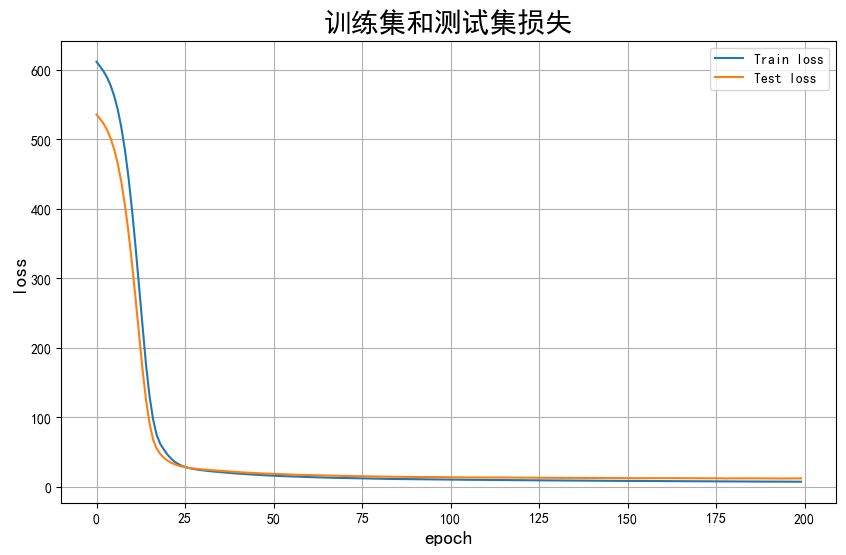

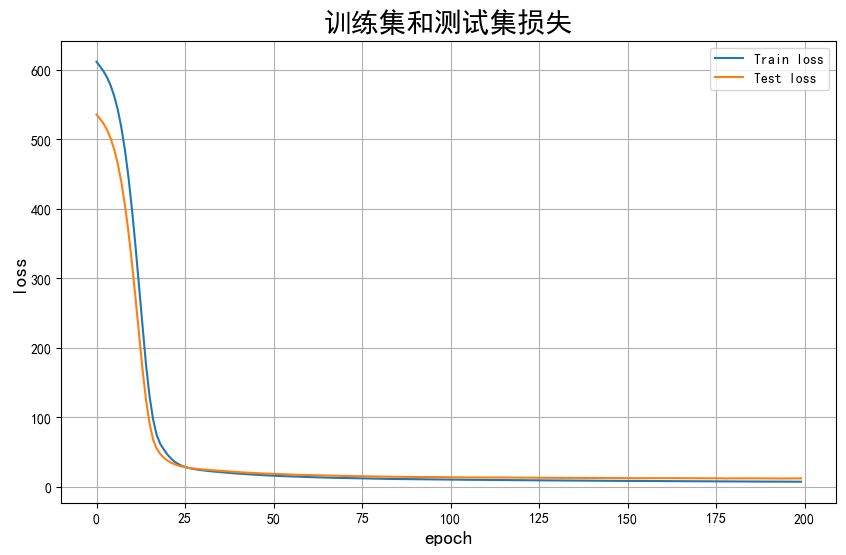

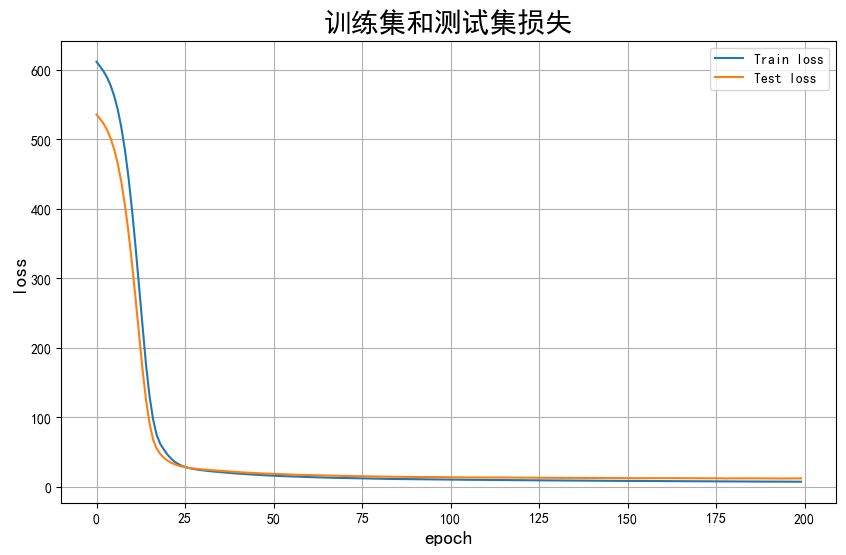

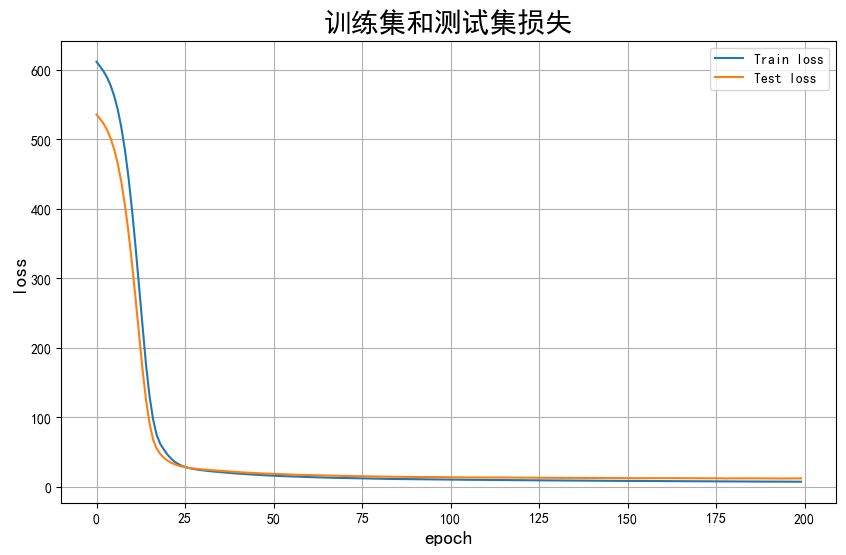

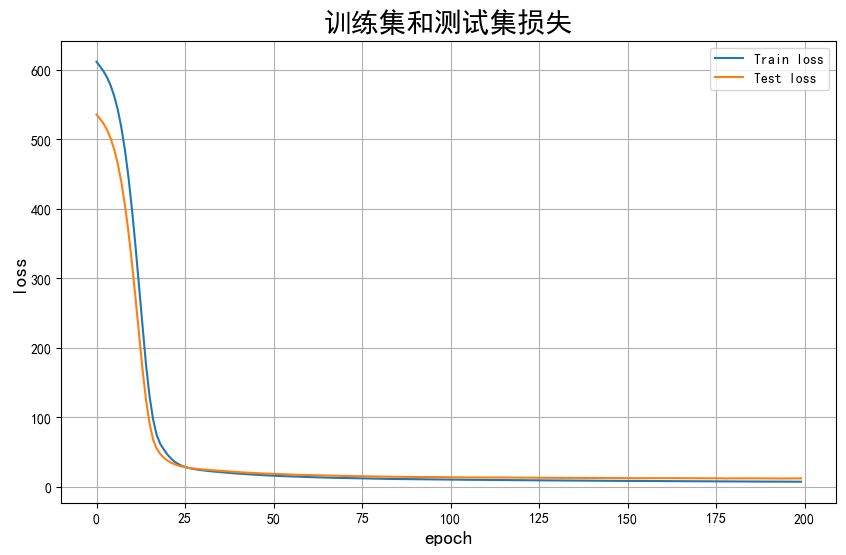

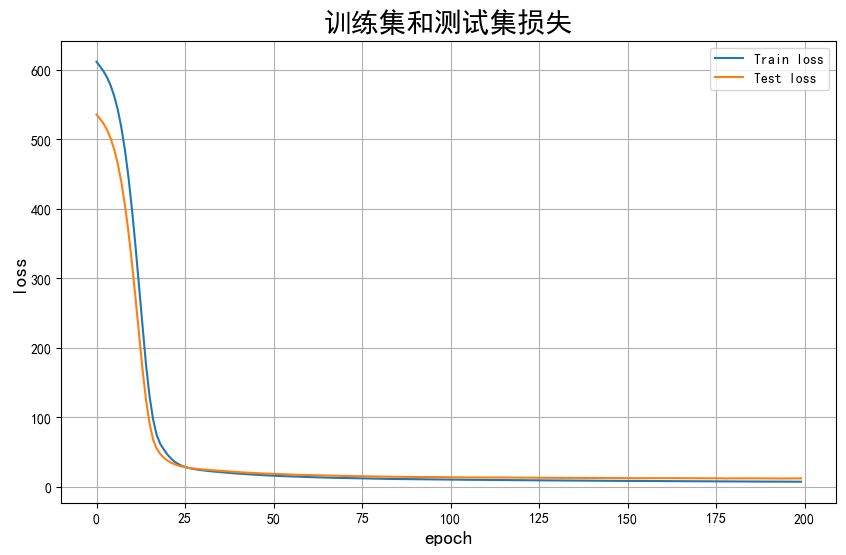

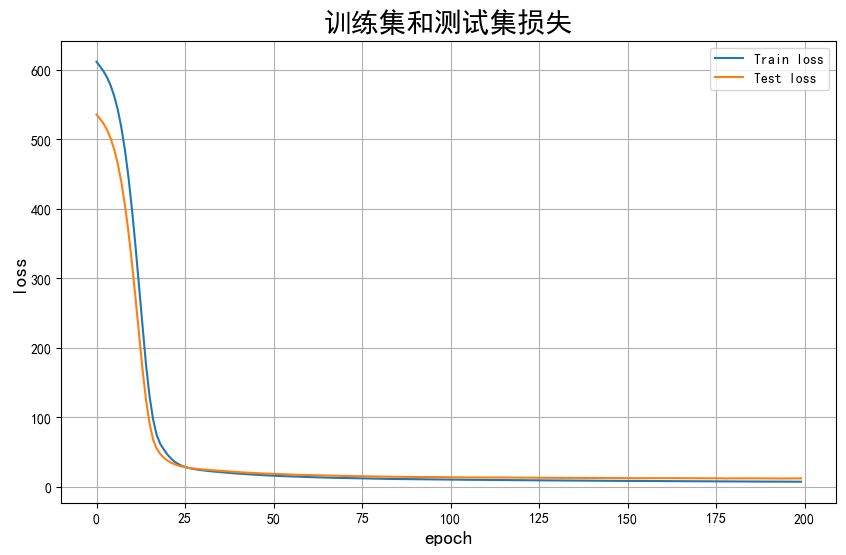

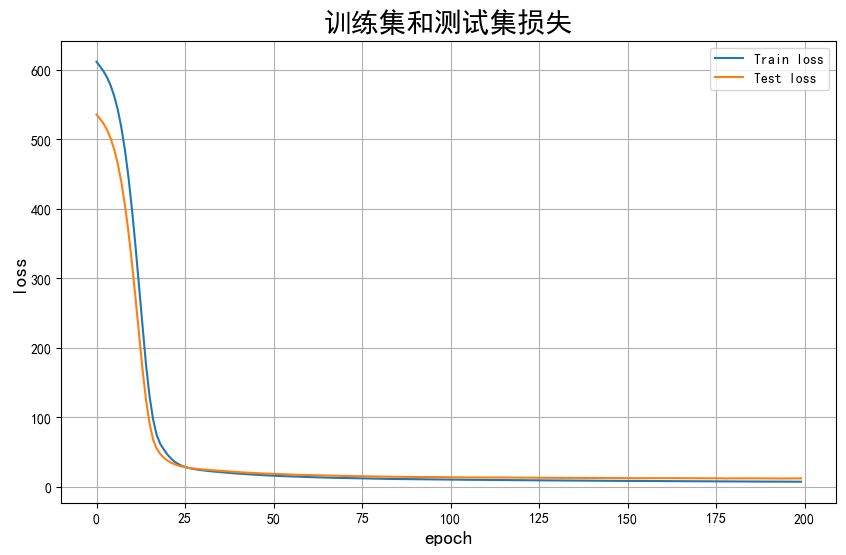

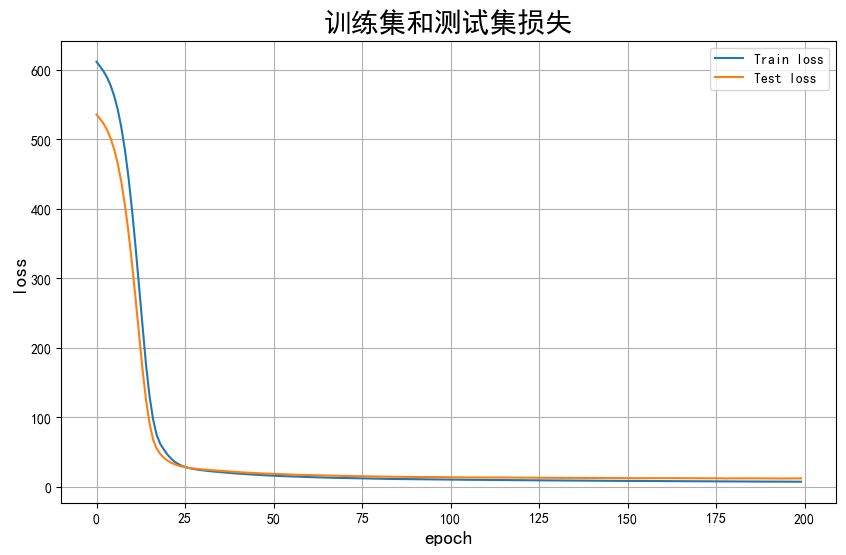

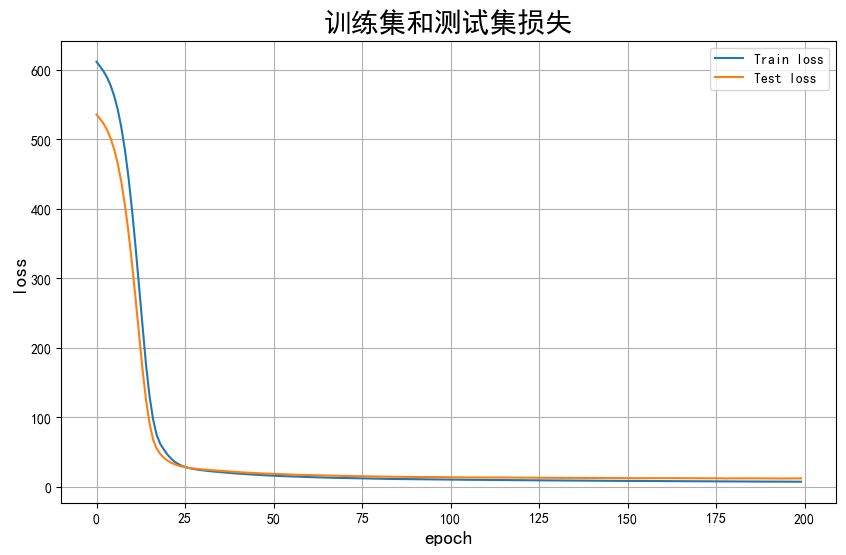

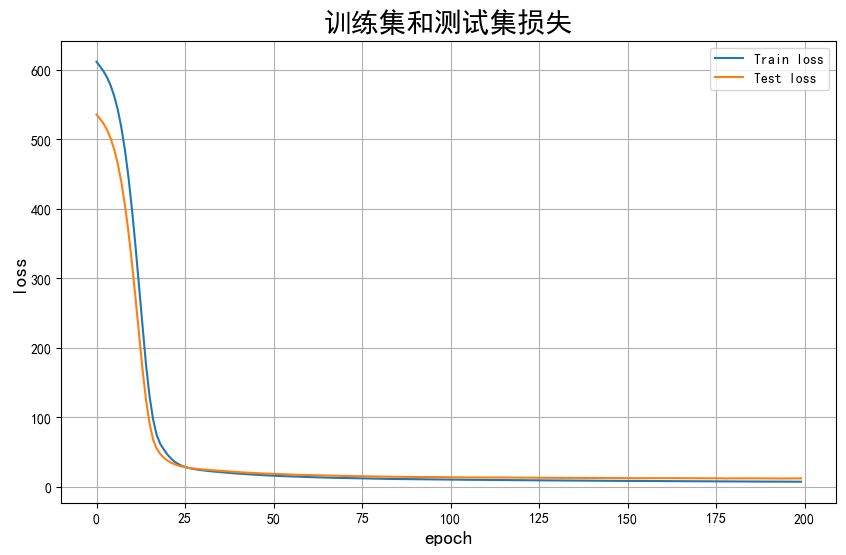

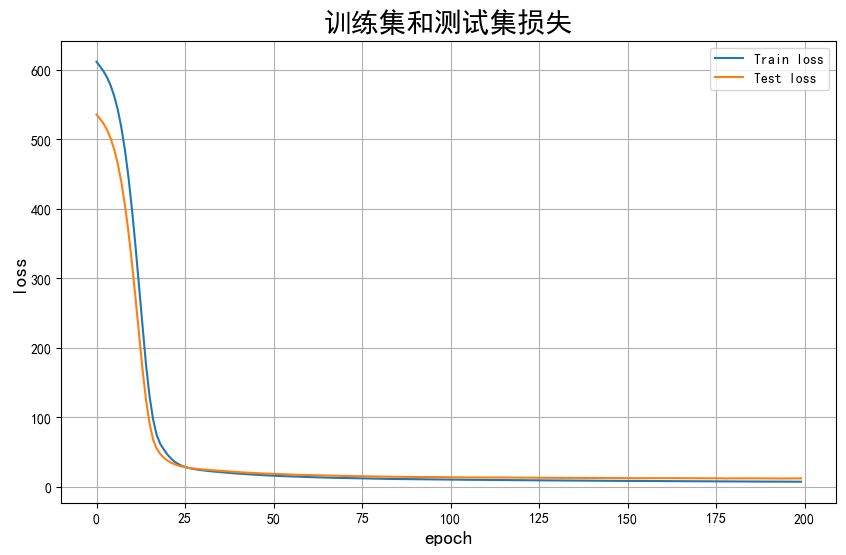

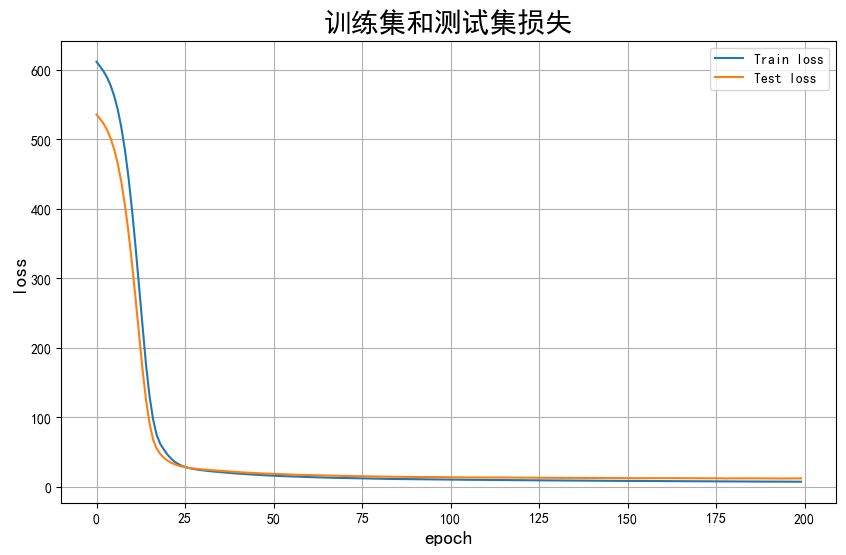

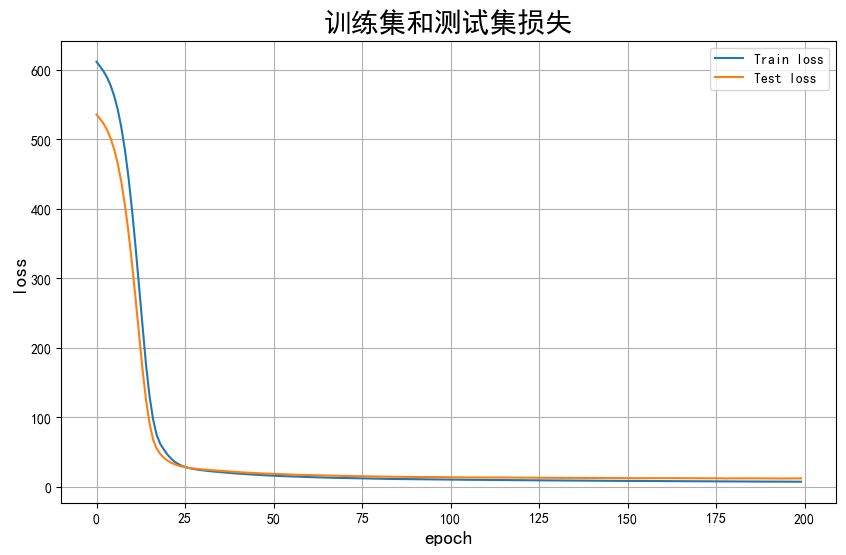

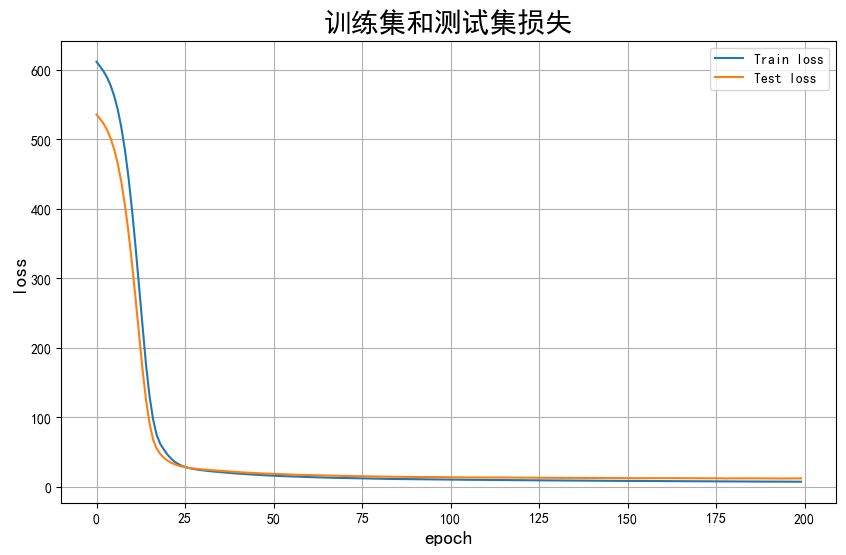

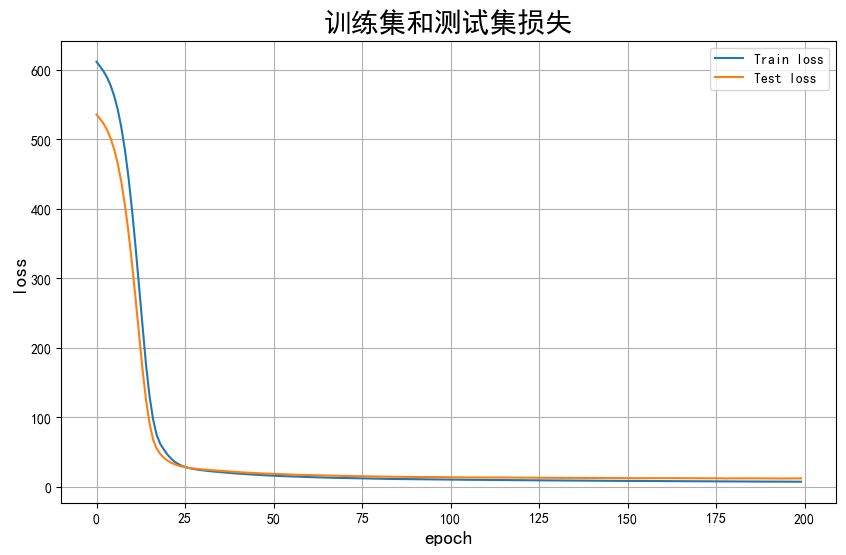

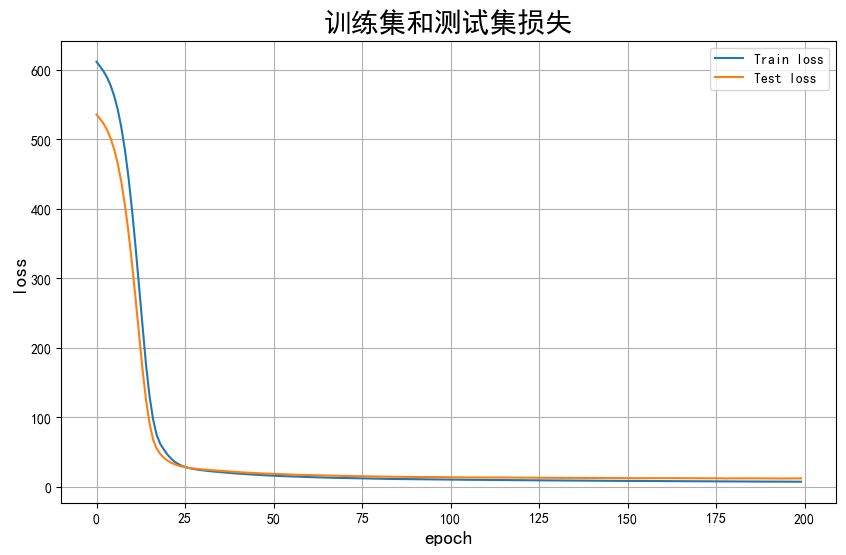

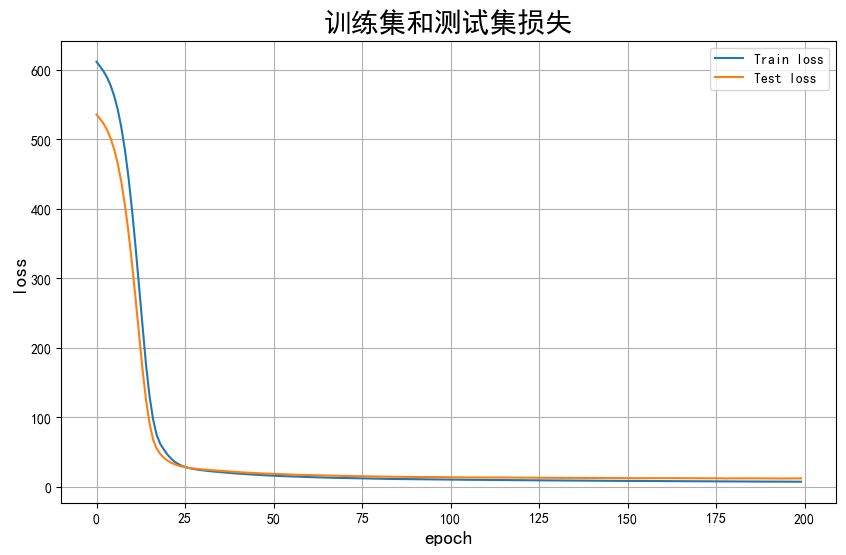

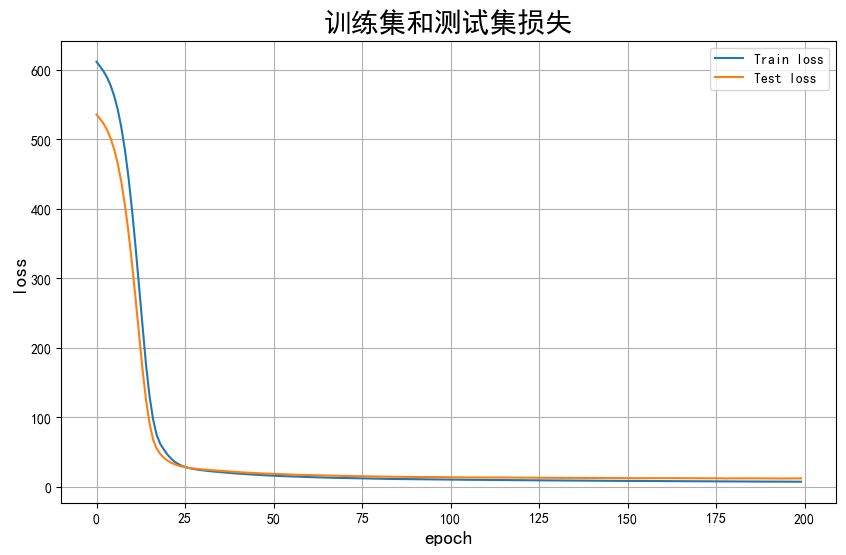

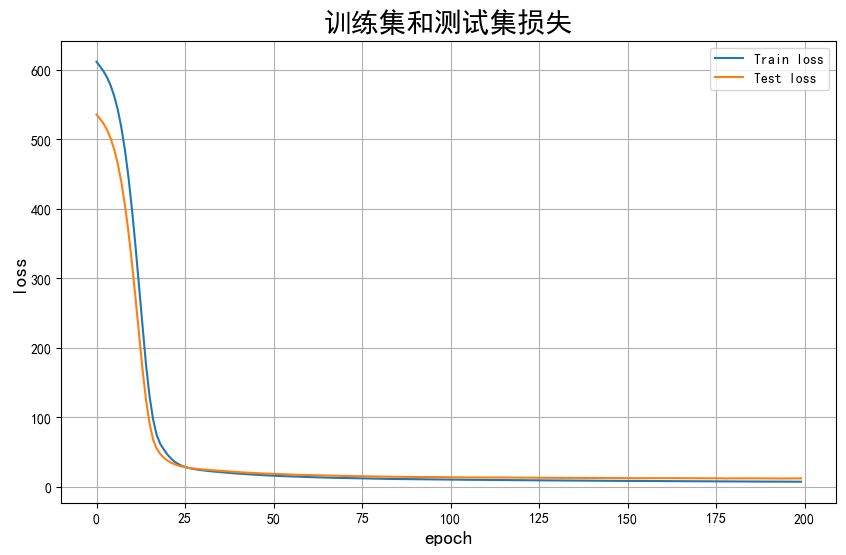

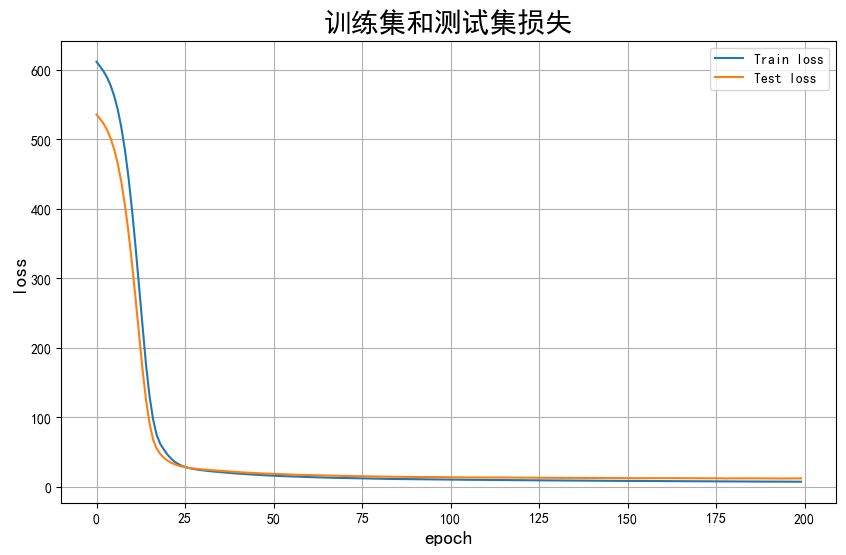

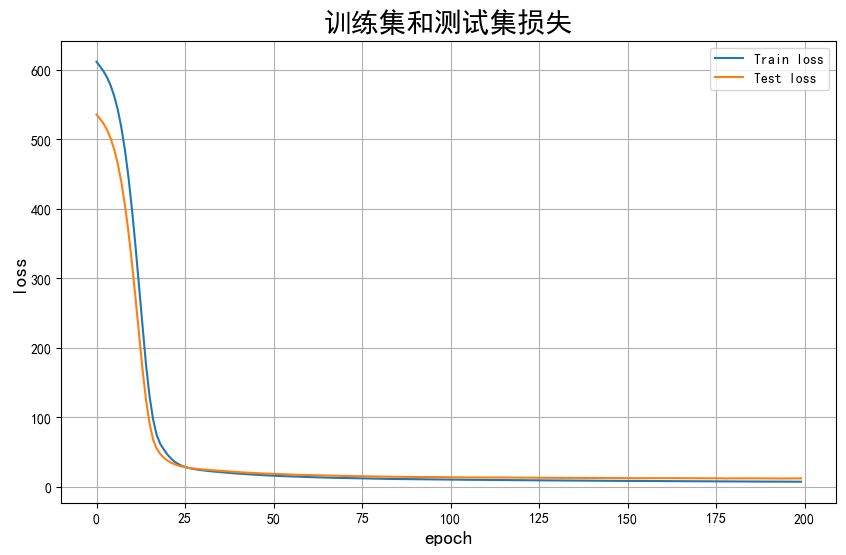

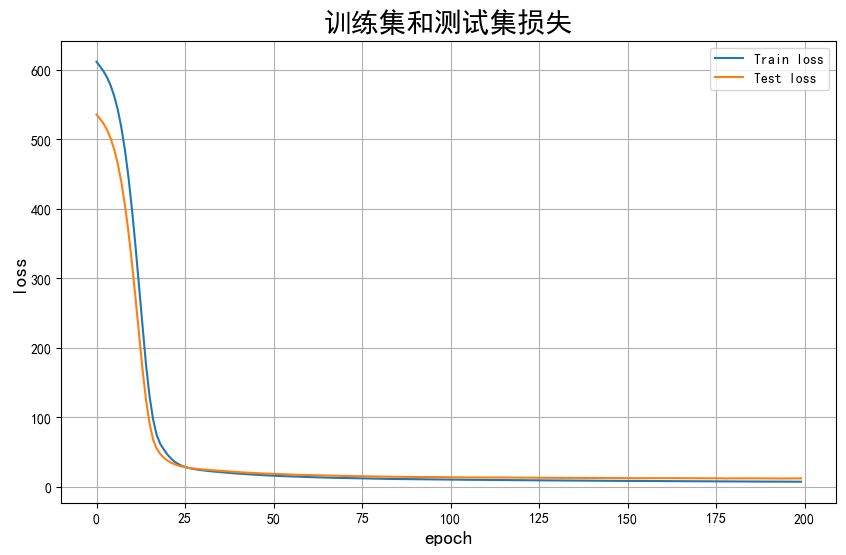

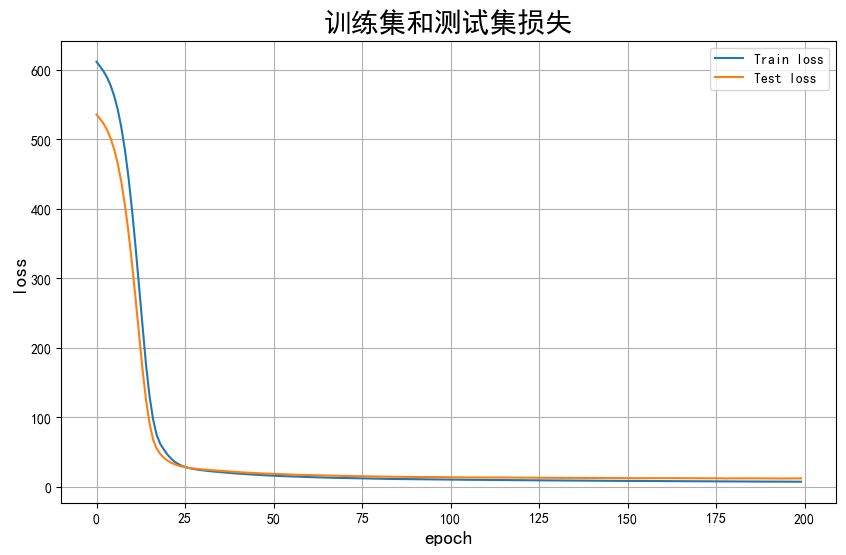

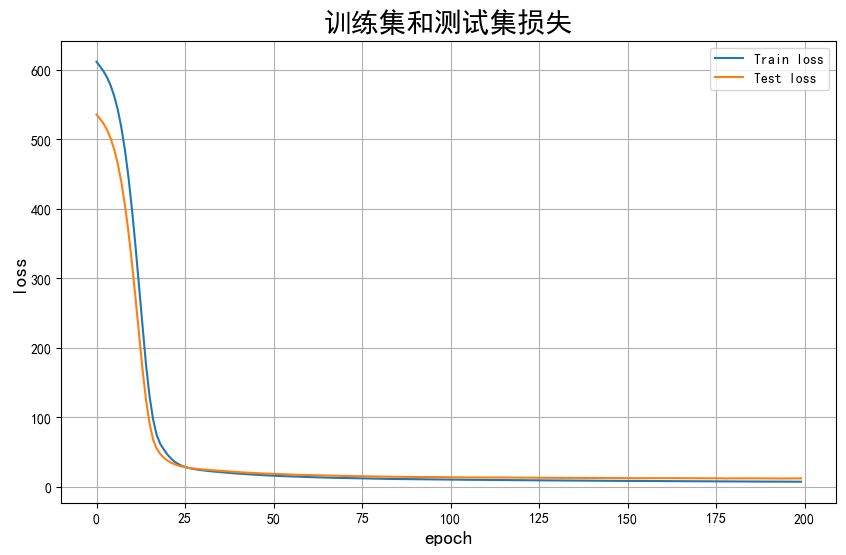

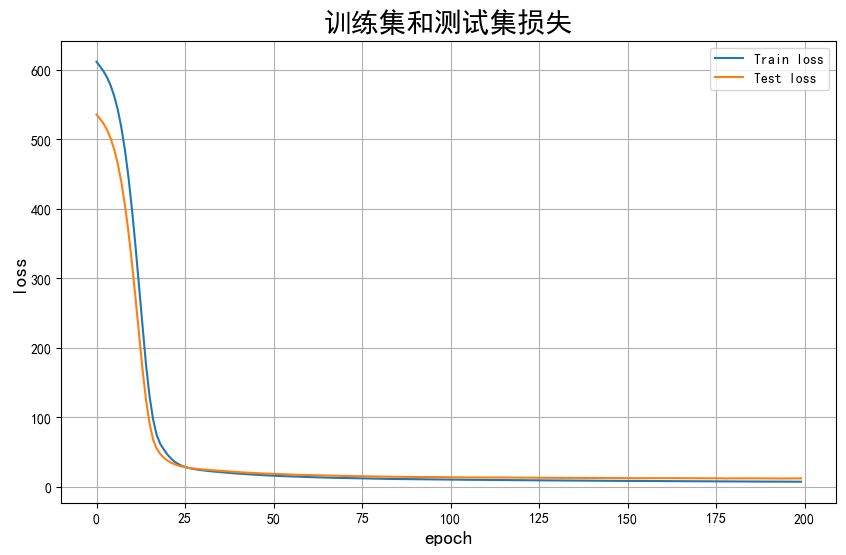

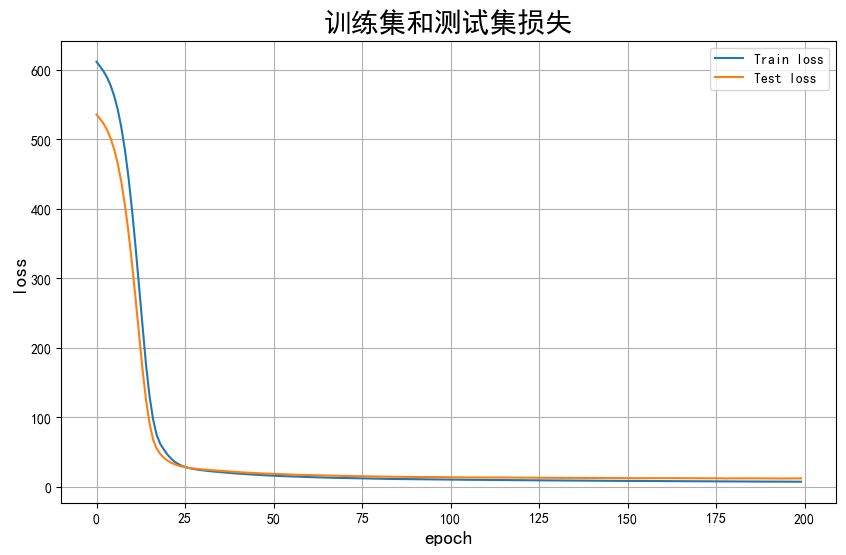

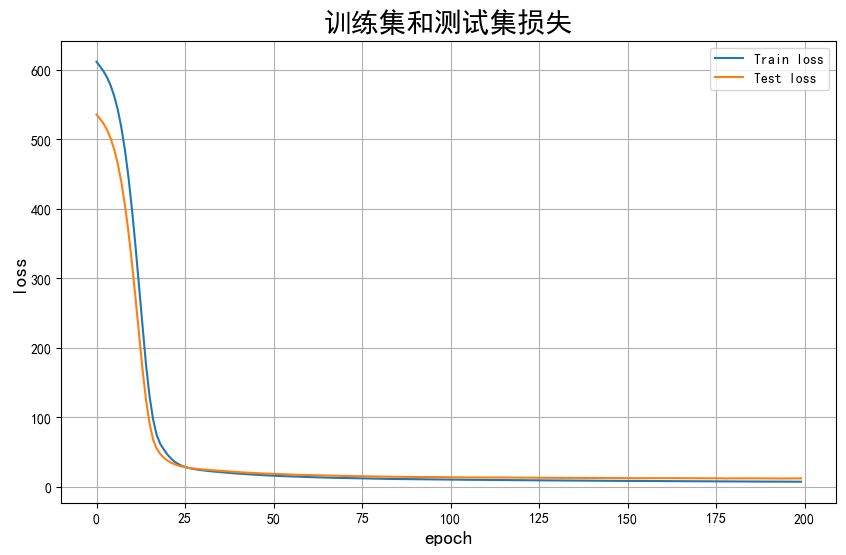

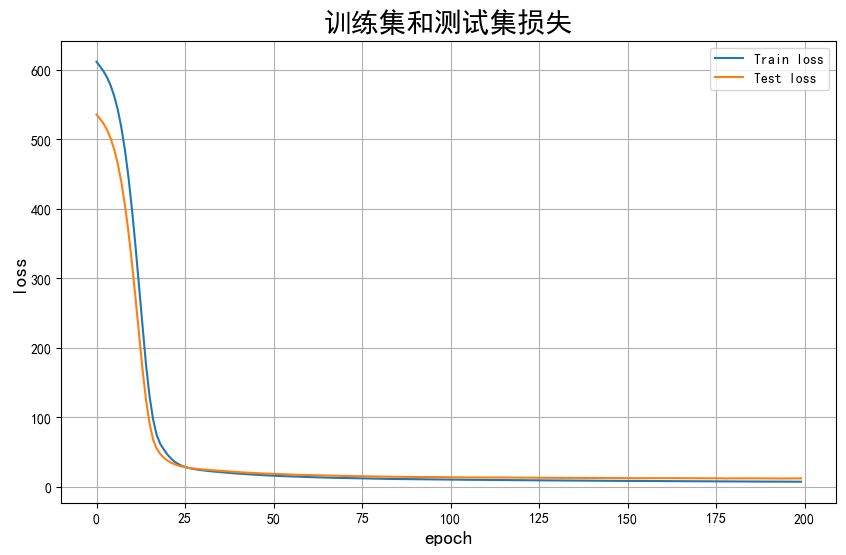

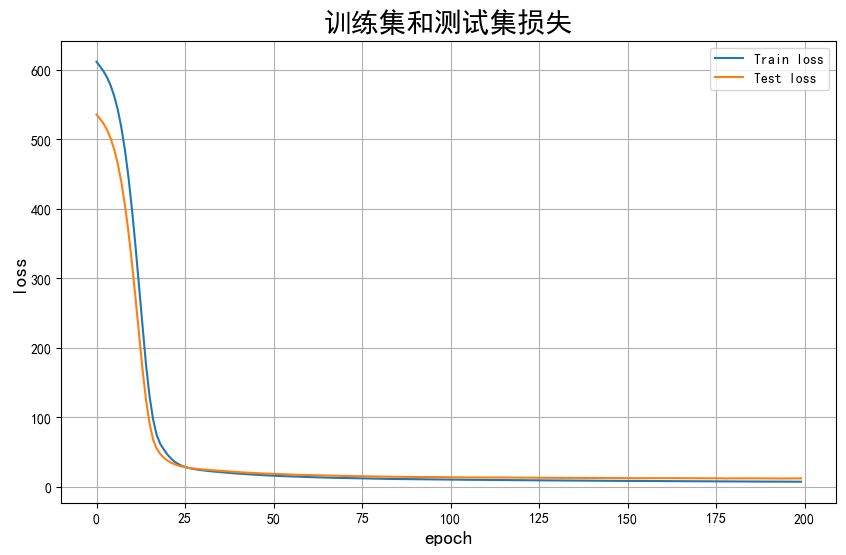

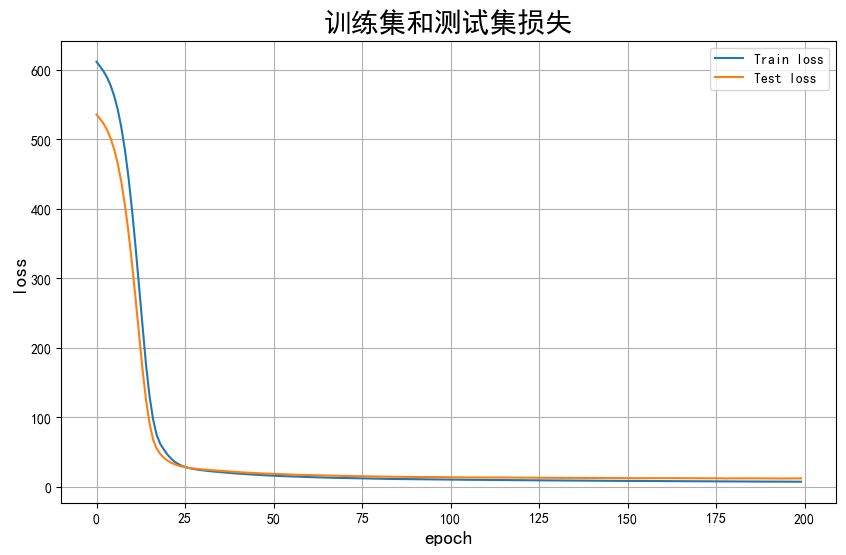

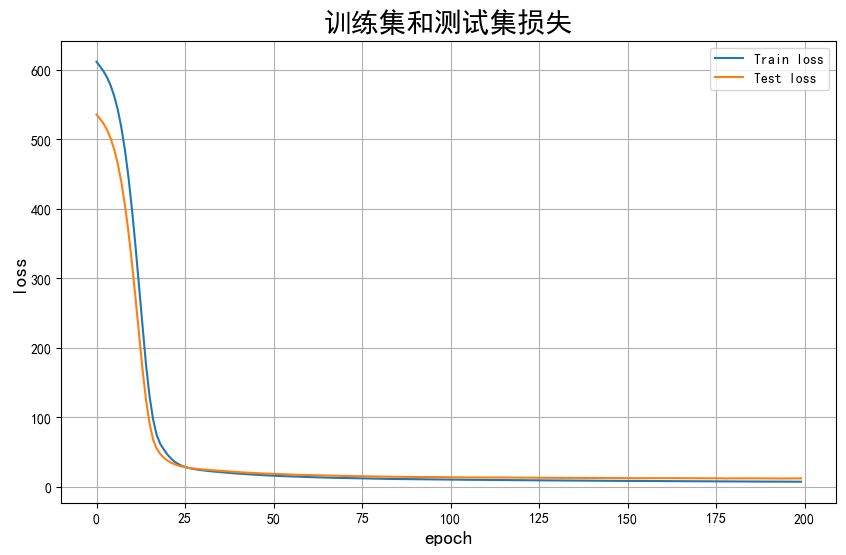

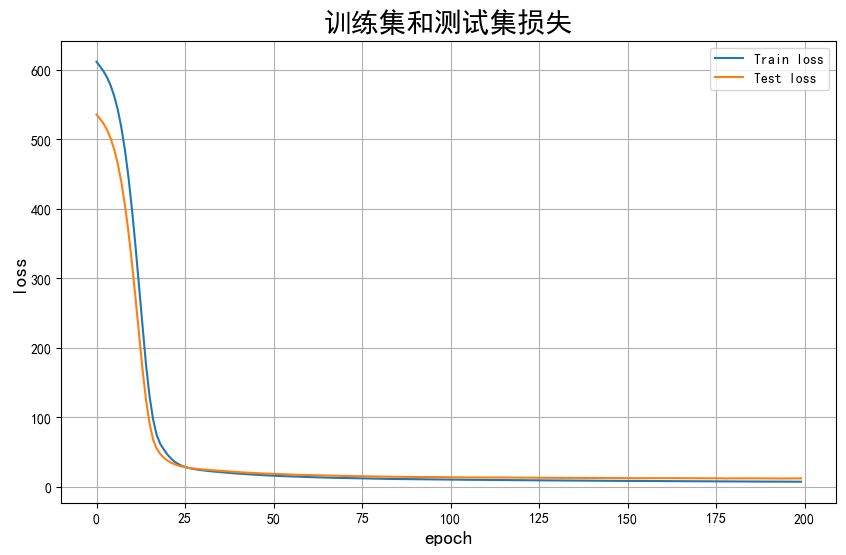

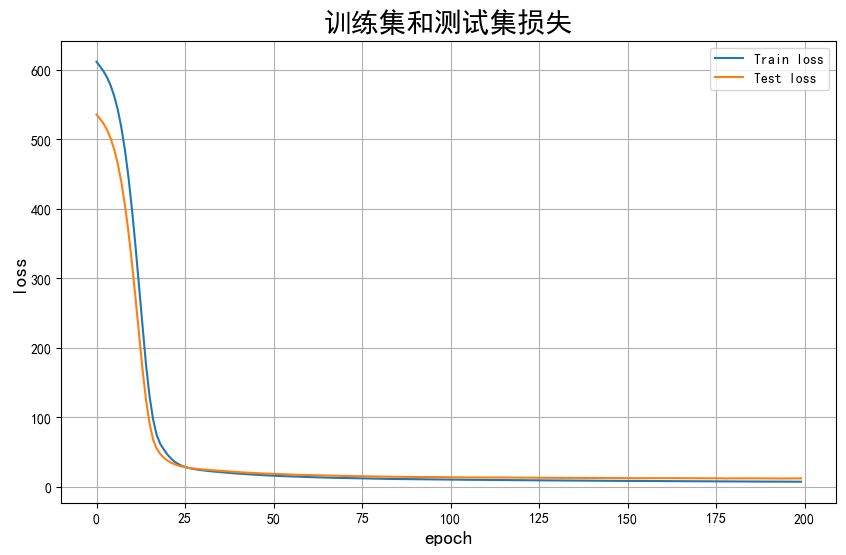

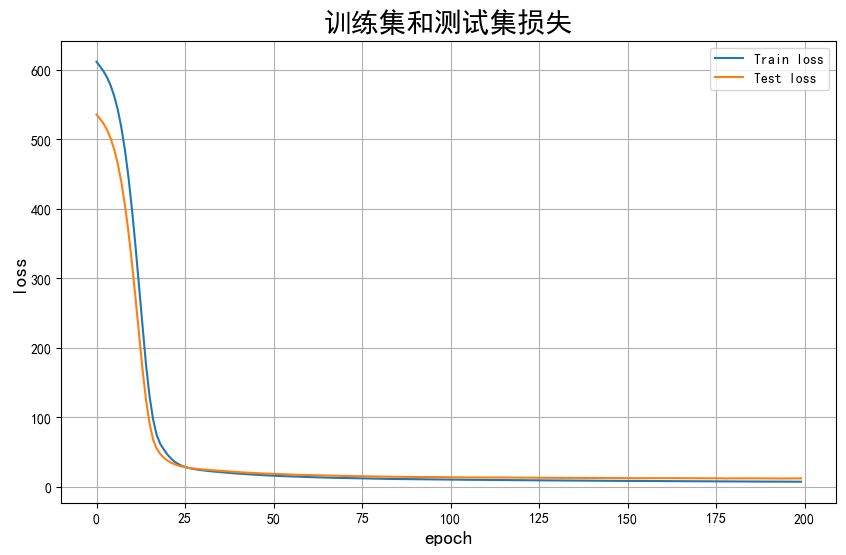

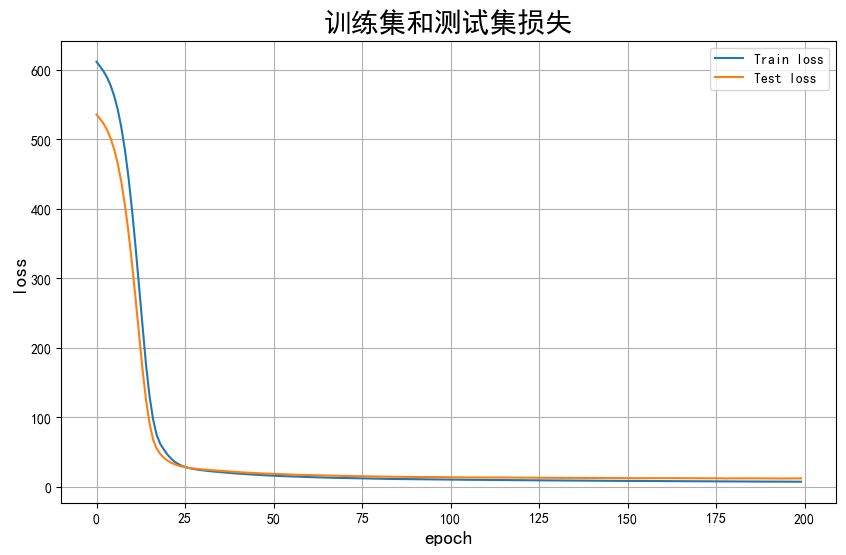

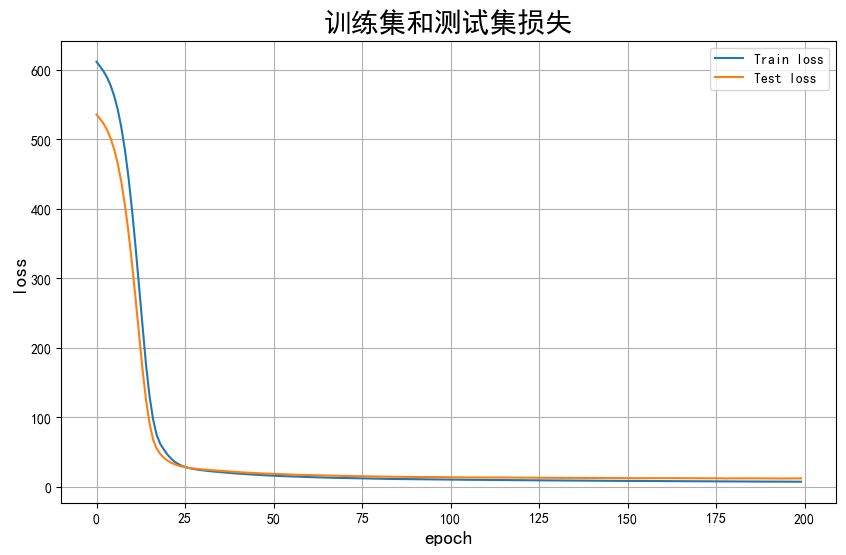

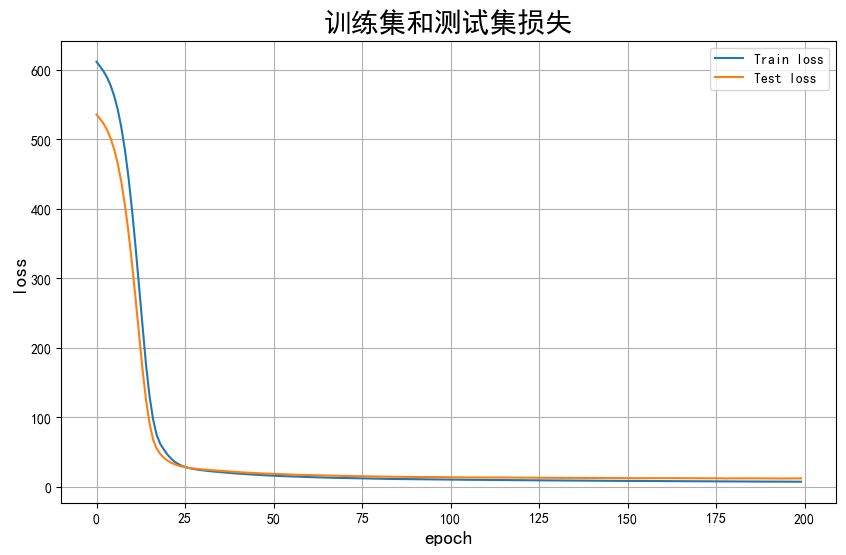

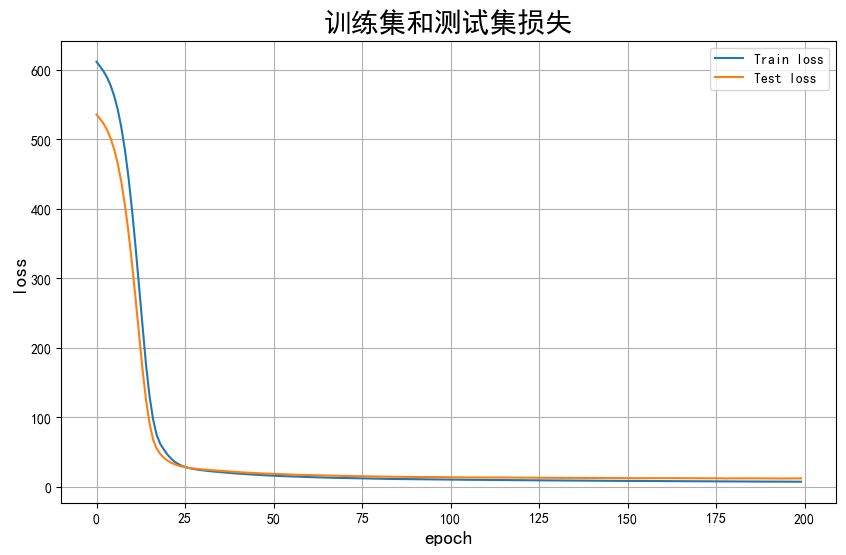

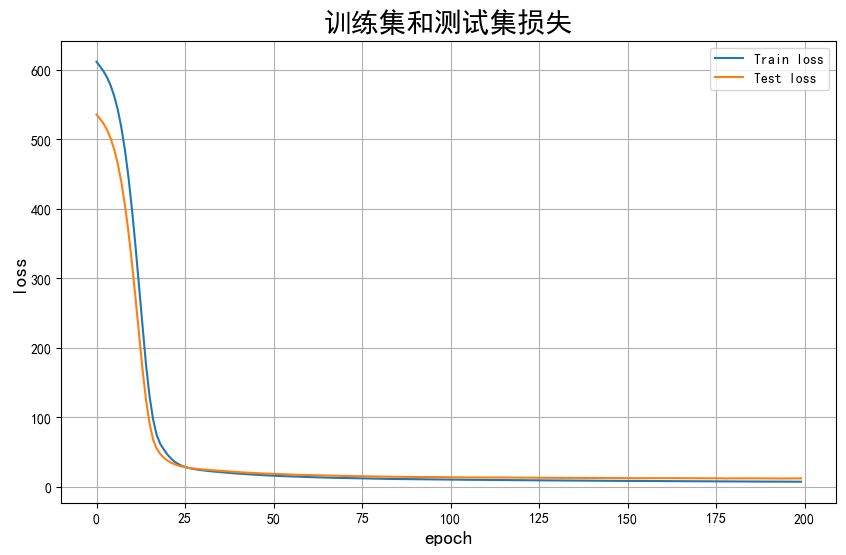

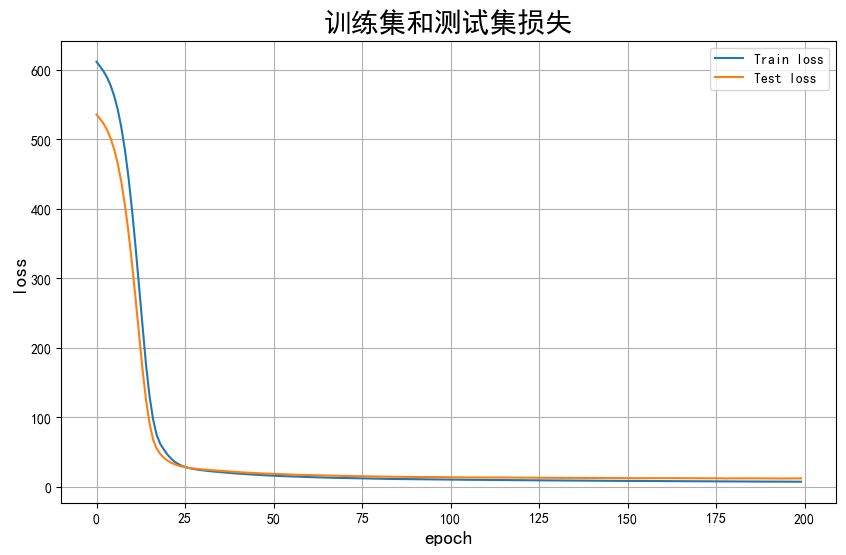

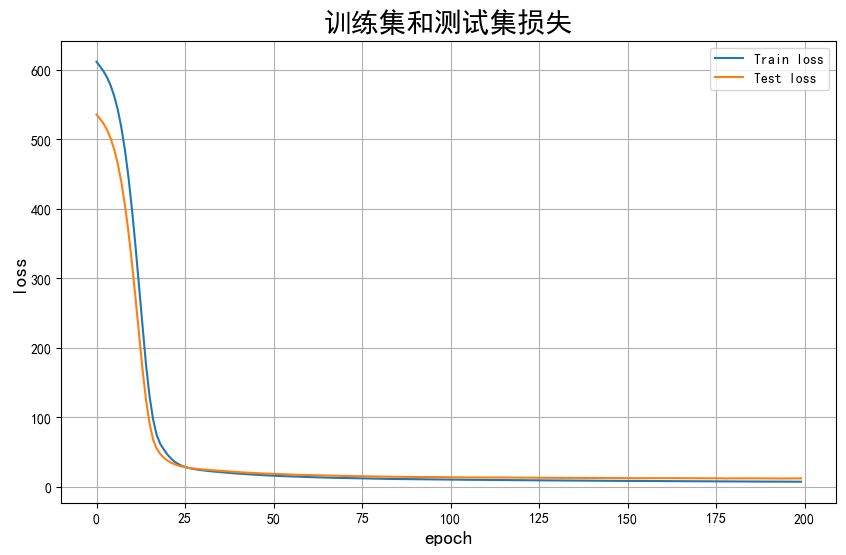

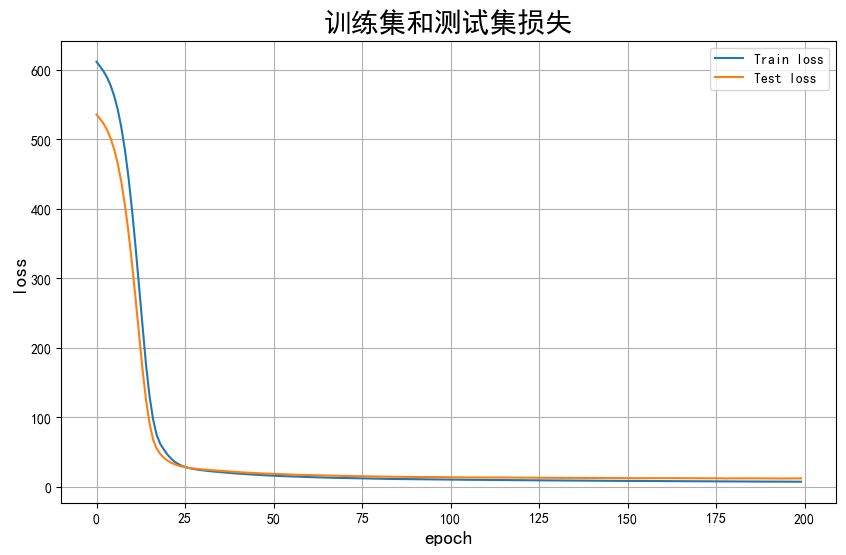

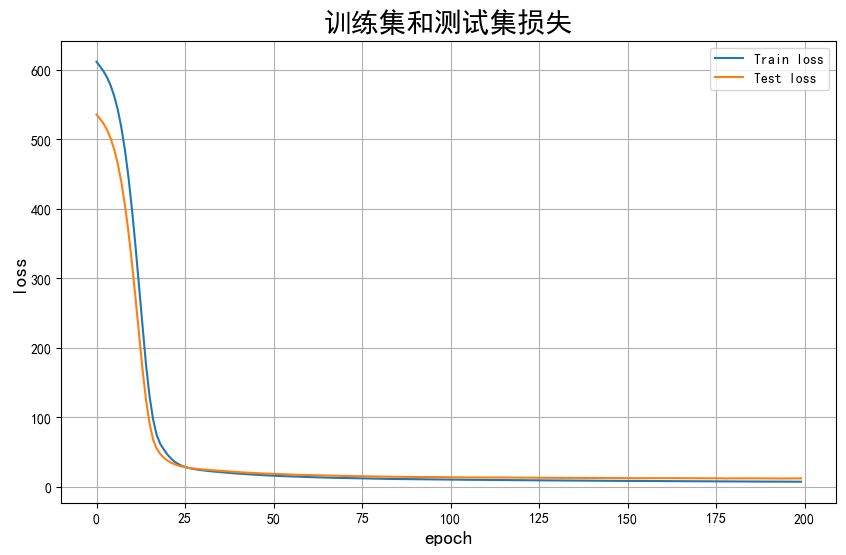

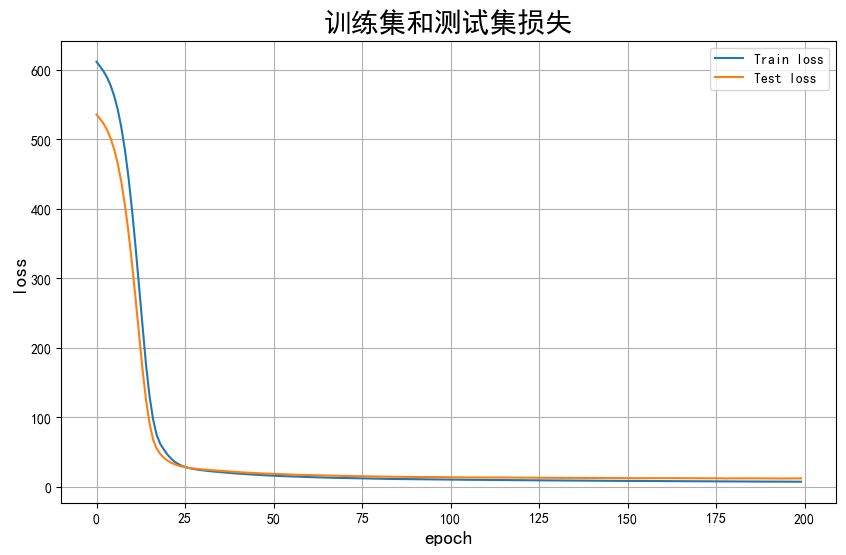

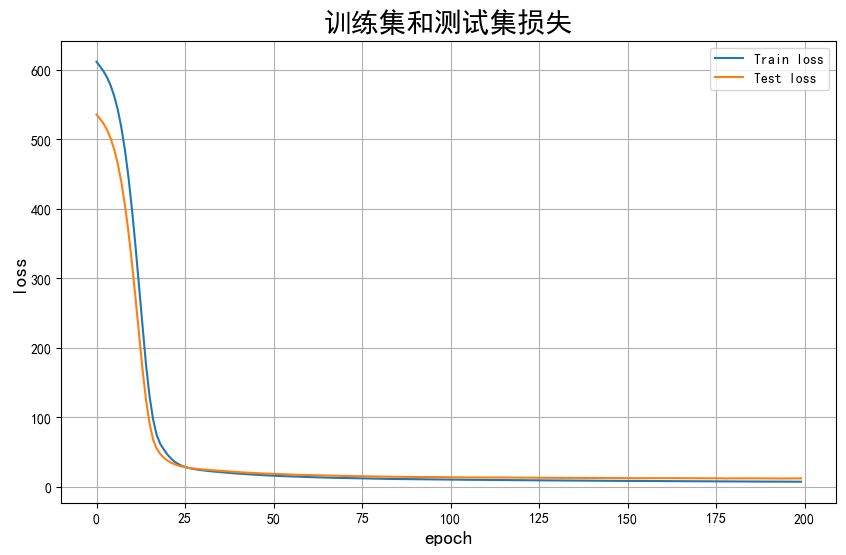

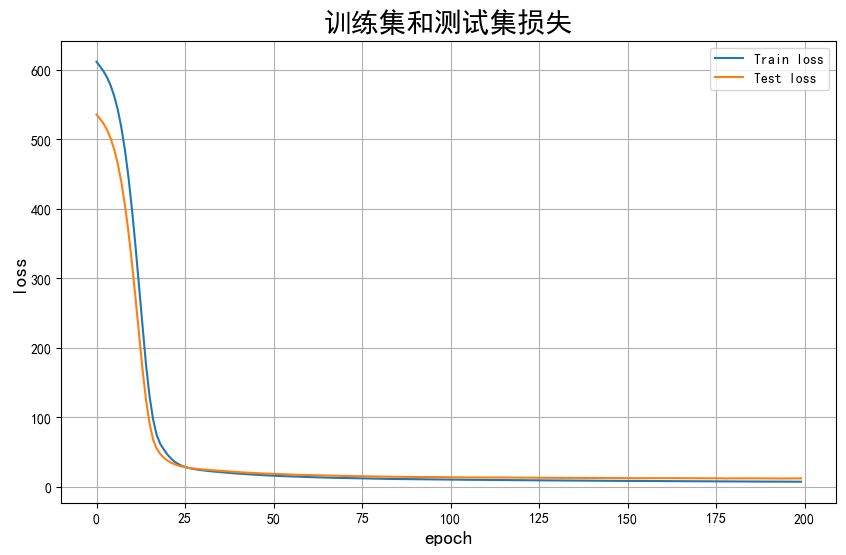

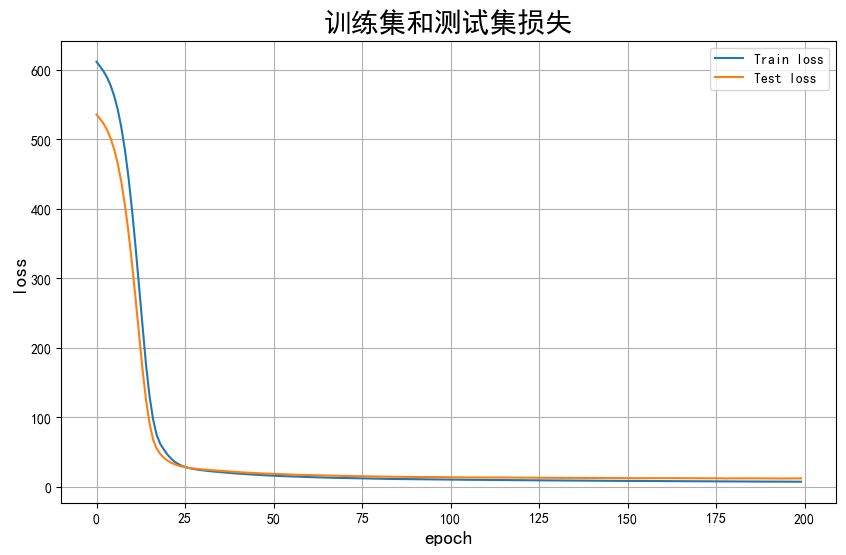

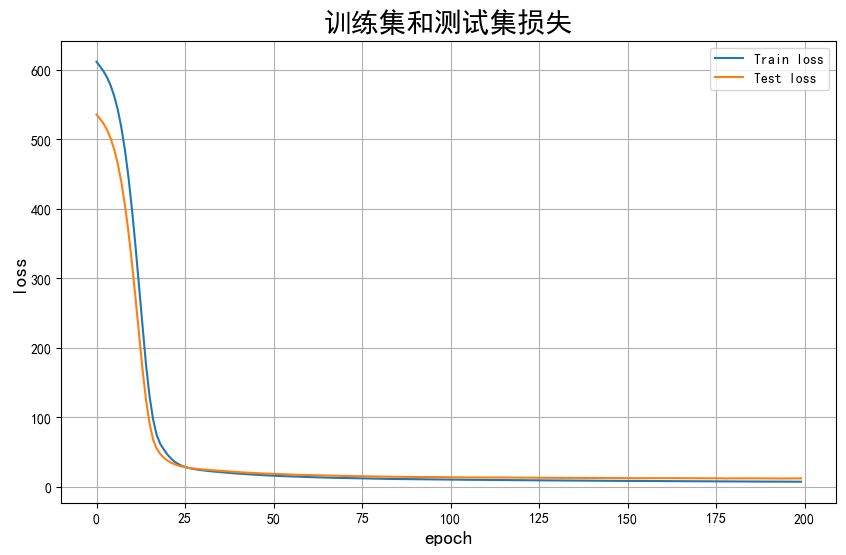

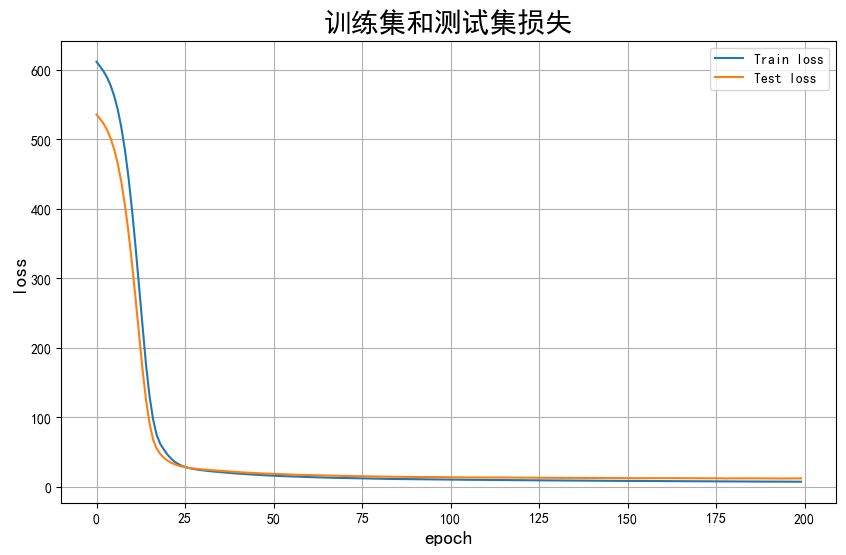

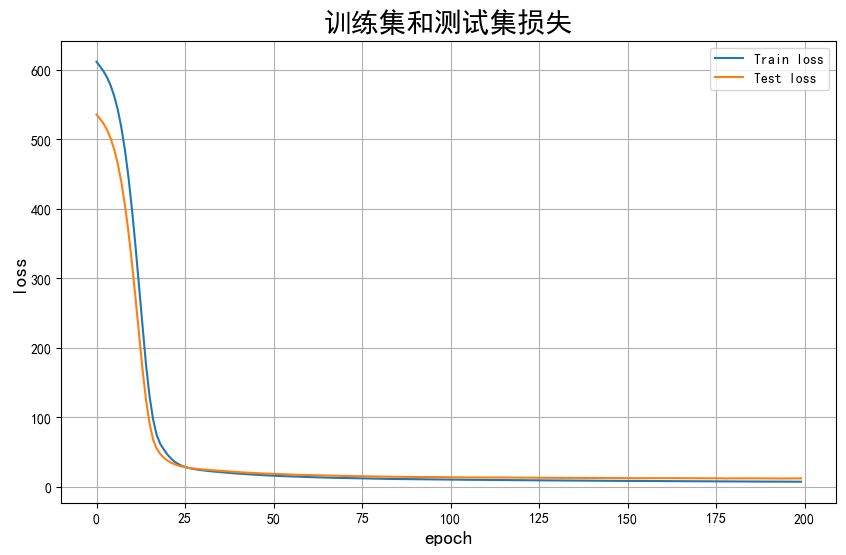

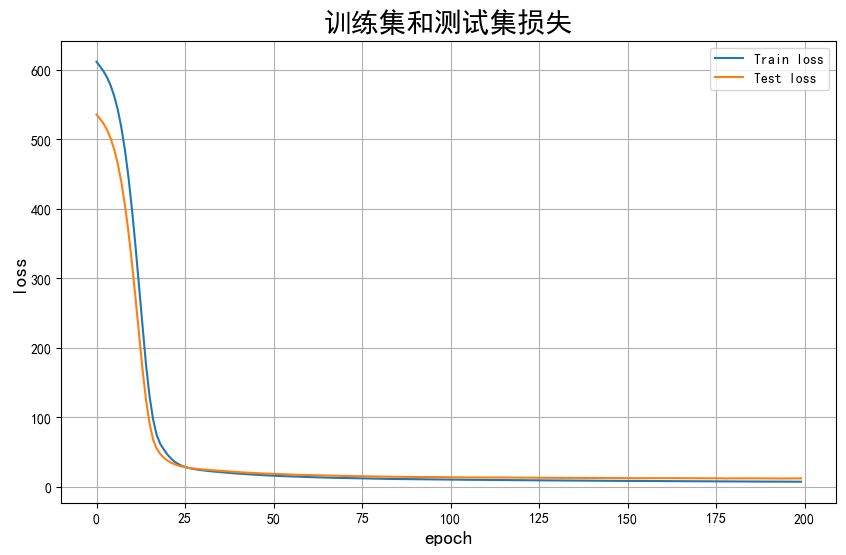

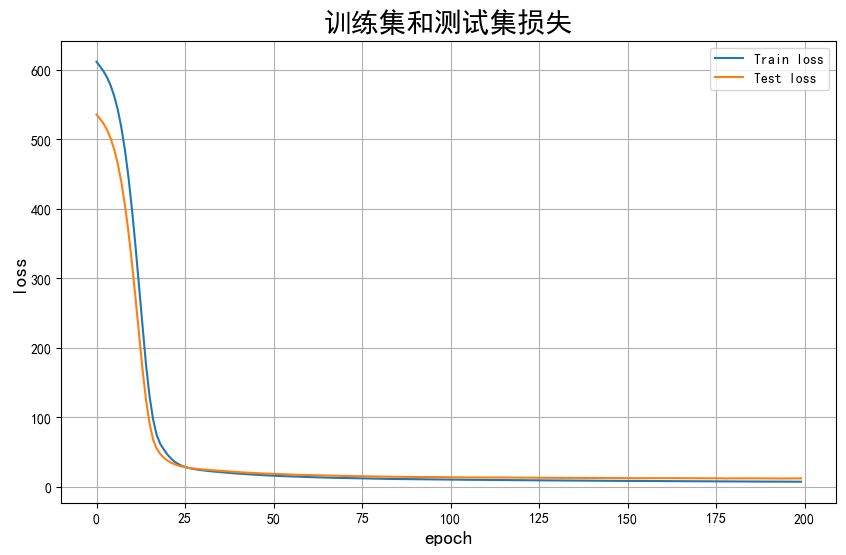

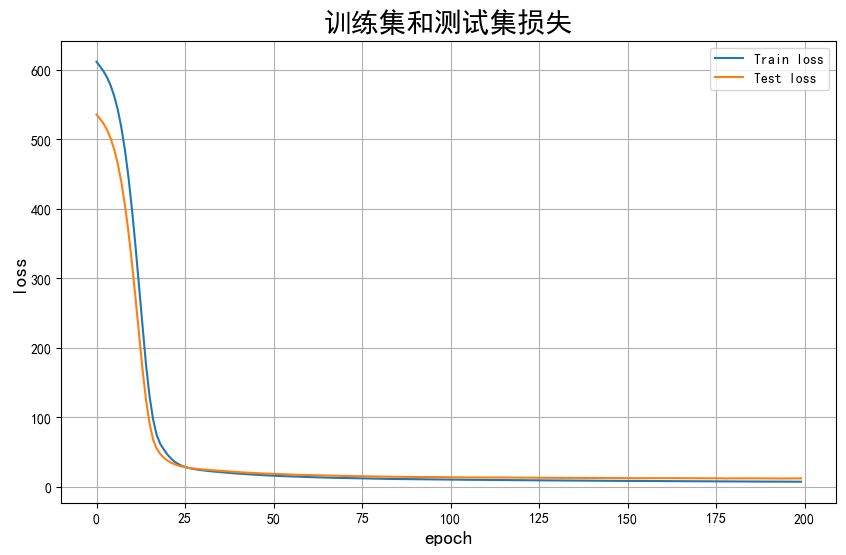

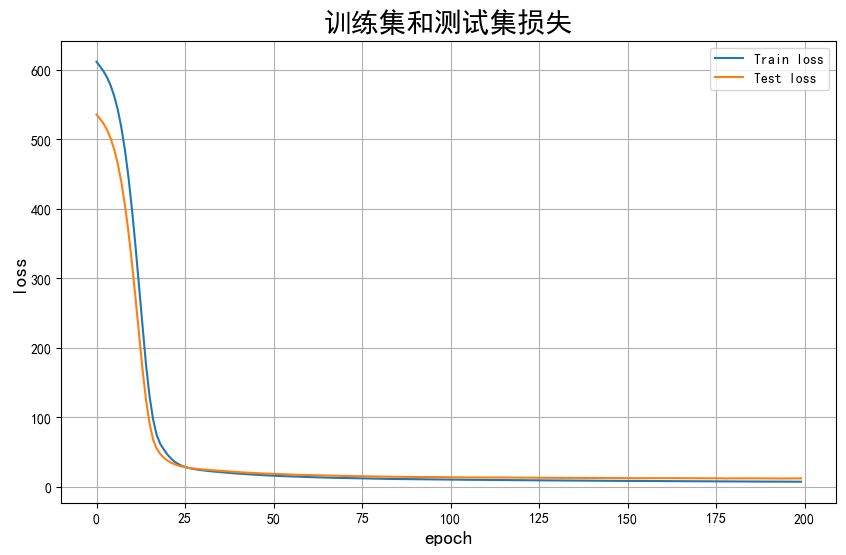

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False
pre =[]
act = []
for i in range(len(test_dataset)):
    p = model(test_dataset[i][0].unsqueeze(0).float())
    pre.append(p.item())
    act.append(test_dataset[i][1].item())
    plt.figure(figsize = (10,6))
    plt.plot(train_losses,label = 'Train loss')
    plt.plot(test_losses,label = 'Test loss')
    plt.xlabel('epoch',fontsize=14)
    plt.ylabel('loss',fontsize=14)
    plt.title('训练集和测试集损失',fontsize = 20)
    plt.grid(True)
    plt.legend()
    plt.show()

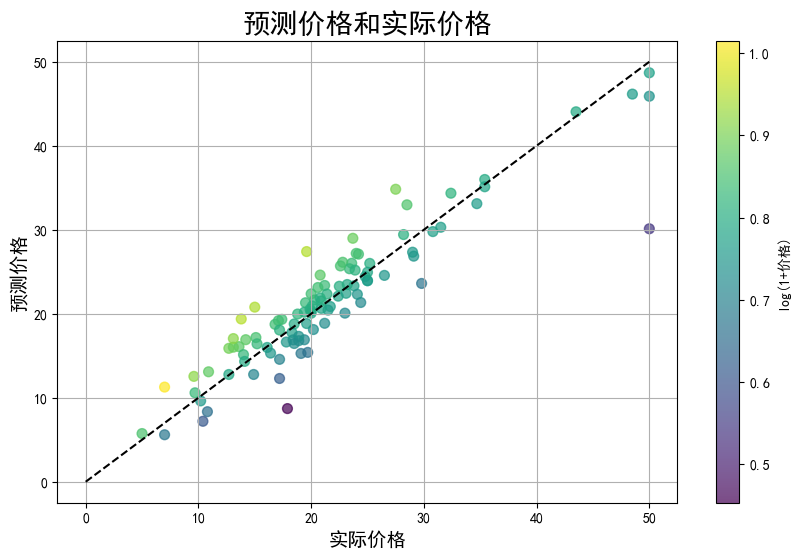

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False
pre =[]
act = []
for i in range(len(test_dataset)):
    p = model(test_dataset[i][0].unsqueeze(0).float())
    pre.append(p.item())
    act.append(test_dataset[i][1].item())
plt.figure(figsize = (10,6))
plt.scatter(act,pre,
            c = np.arctan2(pre,act),
            s = 50,
            alpha=0.7,
            cmap = "viridis")
plt.colorbar(label = 'log(1+价格)')
plt.plot([0,50],[0,50],'--k')
plt.xlabel("实际价格",fontsize = 14)
plt.ylabel("预测价格",fontsize = 14)
plt.title("预测价格和实际价格",fontsize = 20)
plt.grid(True)
plt.show()    

In [ ]:

#模式评估
model.eval()
with torch.no_grad():
    #训练集评估,计算均方根误差
    train_preds = model(X_train)
    train_rmse = torch.sqrt(criterion(train_preds,y_train))
    mse = mean_squared_error(y_train,train_preds)
    mae = mean_absolute_error(y_train,train_preds)
    r2 = r2_score(y_train,train_preds)
    #测试集评估
    test_preds = model(X_test)
    test_rmse = torch.sqrt(criterion(test_preds,y_test))
    mse = mean_squared_error(y_test,test_preds)
    mae = mean_absolute_error(y_test,test_preds)
    r2 = r2_score(y_test,test_preds)
print(f'\n最终结果:')
print(f'Train RMSE{train_rmse:.4f}')
print(f'Test RMSE:{test_rmse:.4f}')
print(f'MSE:{mse:.4f}')
print(f'MAE:{mae:.4f}')
print(f'R^2:{r2:.4f}')
    #使用测试样本进行预测
sample_input = X_test[0].unsqueeze(0)
model.eval()
with torch.no_grad():
    predicted_value = model(sample_input).item()
    
print(f'\n示例预测:')
print(f'输入特征: {sample_input.squeeze().numpy().round(2)}')
print(f'预测价格: {predicted_value:.2f} 万美元')
print(f'真实价格: {y_test[0].item():.2f} 万美元')


最终结果:
Train RMSE2.7402
Test RMSE:3.5186
MSE:12.3805
MAE:2.3819
R^2:0.8312

示例预测:
输入特征: [-0.4  -0.5  -1.01 -0.28 -0.4   0.14  0.56 -0.55 -0.51 -0.65 -0.77  0.43
 -0.48]
预测价格: 27.16 万美元
真实价格: 23.60 万美元
